# Derive recalibration for dQ/dx with ACPT

In [1]:
%load_ext autoreload
%autoreload 2

import math
from itertools import product
from copy import deepcopy
import uproot
import awkward
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import binned_statistic
import scipy as sp
import seaborn as sns

import matplotlib
from matplotlib.colors import LogNorm

matplotlib.rcParams.update({'font.size': 12})

from calo_likelihood import caloLikelihood
from general_functions import *
from loaders import *
from plotter import plotter
from initializers import initialisation_for_caloriemtry_acpt

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

In [3]:
today = 'calorimetry/paper'

In [4]:
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt/calibration/plane0/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt/calibration/plane1/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt/calibration/plane2/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt/data_mc_cali/plane0/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt/data_mc_cali/plane1/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt/data_mc_cali/plane2/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt/data_mc/plane0/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt/data_mc/plane1/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt/data_mc/plane2/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt/pitch_phi/plane0/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt/pitch_phi/plane1/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/acpt/pitch_phi/plane2/

In [4]:
save_folder = '/home/nic/Dropbox/MicroBooNE/_fig/' + today + '/acpt/'
save_folder_calibration = save_folder+'calibration/'
save_folder_data_mc = save_folder+'data_mc/'
save_folder_data_mc_cali = save_folder+'data_mc_cali/'
save_folder_pitch_phi = save_folder+'pitch_phi/'

In [5]:
branches = [
    'run',
    'sub',
    'evt',
    
#     'generation',
    'backtracked_pdg',
#     'backtracked_e',
    'backtracked_purity',
    'backtracked_completeness',
    'backtracked_overlay_purity',
#     'backtracked_start_x',
#     'backtracked_start_y',
#     'backtracked_start_z',
#     'backtracked_start_t',
#     'backtracked_sce_start_x',
#     'backtracked_sce_start_y',
#     'backtracked_sce_start_z',
    
#     'nplanehits_U',
#     'nplanehits_V',
#     'nplanehits_Y',
#     'trk_score',

#     'trk_start_x',
#     'trk_start_y',
#     'trk_start_z',
    
#     'trk_sce_start_x',
#     'trk_sce_start_y',
#     'trk_sce_start_z',

#     'trk_end_x',
#     'trk_end_y',
#     'trk_end_z',
    
#     'trk_sce_end_x',
#     'trk_sce_end_y',
#     'trk_sce_end_z',
    
    'trk_theta',
    'trk_phi',

    'trk_dir_x',
    'trk_dir_y',
    'trk_dir_z',

    'trk_len',
    
#     'dqdx_u',
#     'dqdx_v',
#     'dqdx_y',

    'dedx_u',
    'dedx_v',
    'dedx_y',

    'rr_u',
    'rr_v',
    'rr_y',

    'pitch_u',
    'pitch_v',
    'pitch_y',
    
#     'x_u',
#     'x_v',
#     'x_y',
    
#     'y_u',
#     'y_v',
#     'y_y',
    
#     'z_u',
#     'z_v',
#     'z_y',
    
    'dir_x_u',
    'dir_x_v',
    'dir_x_y',
    
    'dir_y_u',
    'dir_y_v',
    'dir_y_y',
    
    'dir_z_u',
    'dir_z_v',
    'dir_z_y',
]

In [6]:
file_folder = '~/Desktop/MicroBooNE/calorimetry_likelihood/v06/'

filenames = {
    'mc': file_folder + 'overlay_acpt/out.root',
    'data': file_folder + 'beam_off_acpt/out.root',
}

split_factors = {
    'mc': [0.01, 0.],
    'data': [1., 0.],
}

folder = "nuselection"
tree = "CalorimetryAnalyzer"

root_file_mc = uproot.open(filenames['mc'])[folder][tree]
entry_split_mc = int(len(root_file_mc) * split_factors['mc'][0])
array_mc_train = root_file_mc.arrays(branches, namedecode="utf-8", entrystop=entry_split_mc)
print("array mc train done")

root_file_data = uproot.open(filenames['data'])[folder][tree]
entry_split_data = int(len(root_file_data) * split_factors['data'][0])
array_data_train = root_file_data.arrays(branches, namedecode="utf-8", entrystop=entry_split_data)
print("array data train done")

array mc train done
array data train done


In [7]:
for i, array in enumerate([array_mc_train, array_data_train]):
    print(i)
    initialisation_for_caloriemtry_acpt(array)

0
1


/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: divide by zero encountered in true_divide
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
def selection_base(array):
    mask = (array['trk_len'] > 20) & (array['trk_dir_y']<=0)
    return mask

def selection_mask_old(array):
    mask = selection_base(array)
    for plane in ['_u', '_v', '_y']:
        for direction in ['_x', '_y', '_z']:
            mask = mask & (  (np.isnan(array['dir'+direction+plane]) == False).all() )
    mask = mask
    return mask

def selection_mask(array):
    mask = selection_base(array)
    for plane in ['_u', '_v', '_y']:
        unit_v = np.sqrt(array['dir_z'+plane]**2 + array['dir_x'+plane]**2 + array['dir_y'+plane]**2)
        mask = mask &\
              (unit_v > 0.9999).all() &\
              (unit_v < 1.0001).all()
    return mask

def selection_efficiency(array):
    base_mask = selection_base(array)
    array_len = len(base_mask)
    print("base selection eff = {:.3f}".format(base_mask.sum()/array_len))
    
    sel_mask = selection_mask(array)
    print("complete selection eff = {:.3f}".format(sel_mask.sum()/array_len))
    print(sel_mask.sum(), array_len)
    
def selection_planes(array):
    aux = []
    for plane in ['_u', '_v', '_y']:
        aux.append(array['first_last_hit_mask'+plane])
    return aux

In [9]:
selection_efficiency(array_mc_train)

base selection eff = 0.970
complete selection eff = 0.969
1333 1375


In [10]:
selection_efficiency(array_data_train)

base selection eff = 0.973


/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in less
  result = getattr(ufunc, method)(*inputs, **kwargs)


complete selection eff = 0.972
62511 64337


In [11]:
muon_train = (abs(array_mc_train['backtracked_pdg']) == 13) & selection_mask(array_mc_train)
data_train = selection_mask(array_data_train)
mc_train_planes = selection_planes(array_mc_train)
data_train_planes = selection_planes(array_data_train)

In [12]:
parameters = ['pitch', 'abs_theta_yx']
parameters_legend_names = ['pitch', r'$\phi$']
parameters_bin_edges = [[0.3, 0.4, 0.7, 1., 1.5, 30], np.linspace(0, np.pi/2, 7)]
dedx_vars = 'dqdx'
dedx_bins = np.linspace(0, 800, 100)
pdgcode_var = 'backtracked_pdg'

In [13]:
caloLike_calibration = caloLikelihood(array_mc_train, quality_mask=muon_train, quality_masks_planes=mc_train_planes)
caloLike_calibration.loadData(array_data_train, overall_data_mask=data_train, overall_data_masks_planes=data_train_planes)
caloLike_calibration.setPdgCodeVar(pdgcode_var)data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAjQAAAFcCAYAAADfxCSpAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8li6FKAAAgAElEQVR4nOydebhVVfnHP19ABJmUIUAQcU5wQMUBFUXRNDNFzYnUqBzKTFPLnMgpB0zLn2mpYZJjVs6amlko2hVFRQ0MnAAZVARlEAHB9/fHWgf23Zxh33vPuRPv53n2c+9ea+21373PPue8513vIDPDcRzHcRynKdOioQVwHMdxHMepK67QOI7jOI7T5HGFxnEcx3GcJo8rNI7jOI7jNHlcoXEcx3Ecp8njCo3jOI7jOE0eV2iaCJJGSFrR0HI0BST1lWSS9sy3X+S4aZIurB8pHcdxnHLiCk0CSV0kXS1piqSlkj6S9KykEyS1amDx7gV6NbAMTZX3gZ7A+HJOKmnPqCj1Lee8juM4Ts1p6C/pRoOkjYDngBXAL4BXgS+A3YGfAq8DExtKPjP7HPi8nHNKam1my8s5Z2PEzFYCHzS0HI7jOE7lcAvNan4HrAvsaGZ3mdlkM3vLzP4E7AS8BSBpHUlXSZolabmkyZKGJyeSdKKkN6OVZ3608vSOfSMkrZC0j6Q3JH0uaaykDSXtJelVSZ9J+qekXok511hykrSTpCckLZS0WNKLknYtdIFxSeWXkn4naR4wLrafIWlinOMDSX+W1DP2SdK7ks5PzdUunvf4Iuf7iqTbJH0Y78UUSd9LzPsHSe/Ee/CupCskrZs4/mJJb0s6VNL/4n0ZK2mL1HmOiuOWSvoPsF2qf40lJ0nbS/qPpGWS3pJ0VB75i92Xvrn7B7wX5x+bOPaYeOzSeN9/Laldon9PSc9LWhS31yQdUOheOo7jOMVxCw0gqTNwEHCRmS1I95vZFwRrDcAVwPeAHwCvAd8C7pT0oZk9LWkn4KY45hmgI5BWMloAFwEnxnnvjdtK4IfAUuDPwK+BowvI3B94FngY2BdYAAyktJJ6epx3ENVf/58C7wA9gGvj+fc2M5P0B+BESVfa6loZxxCsWX8tIF/beP2fA98G3gU2BzrnhgAfAcOBDwlKyM3xflyUmKpnvCffjuf7Y9wGx/PsANwDXA2MAfoD/1fsBkTZ/k54/XYB1gOuB76SZ3je+0JYxjoUeCjO8T6wPM4/AvgN4V4/D/QGbgC6AcfH5cuHo7wj4nm2AZYUk9txHMcpgpmt9RvhC8mAw0uMWw9YBpyaan8A+Ff8/zCCctGxwBwj4rkGJNp+Ftt2SrSdCXycOm5FYv8Owhdyixpc5zTg6Qzjdojy9Ir73Qlf1vslxlQB/1dkju8TFLPeNZDvTOCtxP7FBCWmW6LtaOBLoE3cvxN4PjXPaVH+PeN+39T+icBiYIPEMdvEMRfW4L7sGff75rnPP0i17RXHbhA3A4Y09LPvm29NdYvvswsT+2OB0YX260mmap/Ta+sWP7vfru/z+pJTQBnHbQ60JlhGkjxDsAwAPEWwRrwXlyhOltQ1Nd6ANxL7Of+O11NtXSS1LCDLTgTl5MuMsud4Md0gaYikJyW9L2kRwZcIYGMAM/uQYIk4KY7fBtgN+EOR8+wETDazmYUGSDpJ0vi4JLUYuDJ3zgSzzWxucp/weuWsKf2A/6SOeY7i9APeNLNPcg1m9l+CIpqUr+h9KXBN3WL/r+NS1eJ4bY/HIZvH844GnpT0uKRzJW1VQmbHaRaocsEXhwNnlUvOYkjqHZeZh6S6PHijAXGFJvAW4Vd/v7pOZGaLCUs/hwFTCUtTb8elqBxfWnBUXXVYPPaLdBvZla2sfJbckdSHsPwyjbCMNBA4JHa3Tgy9CRgWlbMTgaqoBNQKSUcCNxI+AA4iWD8uBdZJDU07LefuS0Wf3RrclzQ5uc4ABiS27YEtiIqsmZ1EUPqeIixh/VfSKWW9CMdpZCgEX7wCHEF4v+8I7AHcSlje3aa2c5vZfDNbWEf5ir23s8jwefwB6DQArtAQ3giEX9CnSeqU7ldwBG4HvE1YctorNWRvYNWXu5mtNLNnzewXhC+tOQRfkXLyMjBUUl1fw52BtsBPzOx5M5tCWGJK8y9gBnAKcDzFrTM5+fopOkPnYS/gVTP7tZm9bGZvEZaGaspkQiRakj0yHLO1pPVzDdEnKfnaZ7kvOWVrlRUtfpi9D2xlZm/n2ZYmxv43Xv/XCR/oJ5e8Wsdp2mQNvtg/BgDMl7RA0jOSdik2cRw/OtXcQiGI42OFIIZbJLVJHXOrpMskzSF8xiFpeLQeL4jHPiZpy8S878e//46WmmnxuHzBGwdJejkGIHykEJSRDBAYoxAEcrKk6VHOhyXl+xxOznuoQhDJEkmfKgSF7BD7pOxBF0cpBEYskfSgpI6SDo8WtEWS/pb8XkzIe6ZCcMwSSX9V8EUtJu/+CoEQn8fjbpPUpdgxNcUVmtWcSnBIfTk+zP0kbS7pOGACsIWZLSE4j14m6UhJWypE/xxKcBbOPWRnKkQg9QGGARsRvkTLydWEX/x3SRooabMo06AazvMWwepxtqRNJA0jhK1Xw8LC6C2xryXBslKMe4DpwMOS9otzD5WUc3KeAmwb79dmks4gmIxrym+AQZIuj6/HYcDZJY65G1hEcObeXtJuBEfjZFh8lvsynWDZO0ghoiv3pr8AOF3SBZK2kbSVpGGSbgaIz9UohUinjeNrNpjyPyOO02jQ6uCLG6xA8IWZ5SzI7QnKzyDCD5a3gCdq8QX4LaAL4f31bcLn8ZWpMUcRHPaHAvvHtnWBXxIsSPsTAjYe02oLzo7x7xGEwIWd851c0naEAIBnCVba7wAHEyzeSXYG9gG+ARwAbAtcU+iiJPUgBGTcQ3B3GARcR/A5hOpBF1sDPwG+C5yfmqpnlOkI4OuEH4N/I1jhj4ptg/Mct0uU90DCazqA8KOskLz7EtwW/kwIABlG+AF7v6TyrUI0tPNQY9oID/U1hKWipYQH4hngOKBVHLMOcBUwi/ALfTIwPDHHXgRrxtw4x1vAuYn+EaScxuL8lmo7hvCF2qrIcbsA/yQsIy0CXgB2KXJ908jj9Ar8iPCL43OCn8iB5HFaBbrGa74x4/3sAdwOfBzvxf+AEYn7eDMwH1hIUDJOS94H8jiWkccRN96rdwjWs/EEBbOgU3Bs24Hg2LwsHntM+v5kuS/AOfFZWAmMTbQPi/Mvidc3EfhF7OsJ3A/MjOefTbB4dWro94BvvlVqI2PwRYFjWwCfAN9OtKXfr2NZ0yl4GtAy0XZy/CxqlxgzlRLBFYToTAP2iPu9C3xGjmDN4I0XU2MOJfwQ2jjujyF816ybGPNzYE4ReXIBCn1rcA8LBV10TbTdGD/LkoEY/wdMSOyPIQRVdEq0fS3Ks3li7rcT/WOBq1Ly9CEVIFPnZ6yhH3Lfms5G+CVgwPYNLYtvvvnWtDZC+opMCg2wSVQG3o4/CBZHJeD8xJgsCs1fUvPmPsO2S4y5J8/5BxCiV98j/FhcHI8bHvuzKjSvANekxqwfj/163B8DPJsaczzB17LQ/WkJPBHleoDgs7dRasxJhB94H8ZxS4Hlif6LgempY0YCs1Jt5wEzEvtjWFNJaxev6ZDE3EmF5rN4/sWpzYAjy/WM+ZKTUxJJ6yok+bsS+LeZvdbQMjmO0+SoSfDFo4Rf8D8iRFQOIFgx6uS0W4B0oMR6wD8IX7bfJViWdo77lTg/5A9+KLgUYyGo5OuEHGQvEZaMpko6GGoUdPFFat8KtNVVV2gBjKJ6oMQAgtvE40WOqxGeWM/JwrEEH5NJhDVpx3GcGmFm8yXlgi9+ayk/GknrEBSGNgSl5yAzezL29SZ/4stS7Cyppa2OKt2d1cvMhdia4H5wgZm9Gc+/O9UVjDUCAgowifxBJBb7ao0F08eLcbtC0hMEBexREkEXufEqb825rSV1tNVRZbnAjEJ+gBOA/mb2dhllWAO30DglMbMxZtbCzLa1EO3jOI5TG0oGXxB8ZeYCJ0VH/0EE59fa1LLrAtwoaWtJ3wAuA2621c7H+ZhOUHp+HAMWhhL8SCwx5mPCksnXJPWQtEGBuX4F7CjpN5K+KulA4LfAXWY2oxbXAwQFS9JISbtK6hNl3I7VCkW5gi4KYcDtMehhL4I16OEiCssvgEMVSsAMiDIdqBBh1rZcQrlC4ziO49QL8Ut8R+BBgp/FK4TEmCcRvvz/ayFZ6JHAZoRko2MIETxzanHKvxF8YJ4jRNg8CpxbQsaPCYEa+xOsKNcQcuR8mRjzJWE57CiCc/+rBeZ6nZC/ai9CZvc7gMcI+cnqwgJCZNNDhKW8PwJ3ERQ2CAEXdwC3Rdl2JdzvcvEi4Z4+RfDleYNQ7icvZvZvwvLYdoQaeK8TIlQXseYSV61RdNhxHMdxHMcpiqQxhJI2+zW0LGncQuM4juM4TpPHFRrHcRzHcZo8vuTklMWEKGksIe/AieWSy2laSLoX+NzMRjS0LI7jrH24hSaFQt2NiQp1N6ZJKlq9NY6xPNuk1LgazVvPnEFwwgNAoU7HmIYTp2ZI2kvSQwp1UEzShRmPK/malPN1q+Cz1U6hXs27CtWL35DUEOH1OxAyIlecSr3mCvVt8t3zzStzJY7jlAtXaBJIGkjwGn+ckPTnYkJ8fzGP9J0Jqexz2xaE8MI/13HeLPK2krRhXeYAMLMFZvZJXeepBBmvsT0hXPEc4IOM85Z8Tcr5ulXq2YrcQlBITyFkQr0FuEfS12oqZ0LeGj1bkjoAm1MGhaYhX/PINKrf956EjLHNHklDogJXqKis4zReypVyuDlshHpC/0m1/QqYVoM5TiKEofUs57ypY3cDbiDkarioxNixhJC+qwi5ExYSvvDaJMaMAf6Z+N9S25DY9yPCl8gyQtbO+1LnGU1Inf0BoUbT7UD7Sl9j6rhp5KlXVZvXupyvWwWfrTax7ZjU2IeAZyp93wlK1sOEbKsW//4p+Xw1sdf8YlL1w5rylng/35+nL1fzLJmqvzWhBlvR2kZlli23LSDUPzuoAucaEc8xPk/f28DFif2xeT4DjRBSXmj+vqTqxdVSziGpc84D/g0MbuhnqSlsbqGpzh6EmPokTwAb1+AXyynAI2aWzJlQ53kVkk9dLOktwhuuJyGXwVUZDs9ScTbHGYQ8AX9h9a/T/0i6hJC6+neESrAHEnJIpM/TmfCmPIZQVfbnWa4P6nyNNSXLa1KO56Em5ytFvmdrHUK20qWpsZ8DuylkXy1Kbe97tKI8R0hE9ntCkb9jCNain2W5oEb4mgP0ljQzbo8rZIltyswADpbUPdV+CuG1W4WZLTezDyzkWakxCpR85hKMY/XnzG6Ez5QHJW1Wm/OXwIDtJR2TYezdrGml27sCMhVix3jOoYT38uMqkOlXqyuAV4RKz19OXKGpTk/WNF9/kOgrSjRp70RIalTneSV1kXSapBcIlaoHExSR7mZ2hJndZ2bLSslFsJb8wMzeNLNHgAuBH0pqlx5oIR35coJz5wdm9gHhS/Mcwq+YG8xsqpm9YmaXpw6fbmZnmtn/zOwfhDoiRR2Ny3iNNSXLa1Kn56EW5ytIoWfLzBYBzwMXSOorqYWkrxN+fbcmVEjPN1857vuNwCtm9mOgO6Ei7yOECvAFP/wb+Wv+IiF9/DcIJT/mAeMk7V8BeeqLt4AXCFYKACT1ISSOuy05MN+Sk0JW179Jmi9piaTXtbpm0AhJKyTtI+lVgvV2v9j3HUmTJS2PyuEvJaXL7eQUqA8slBk4l/B5s13i/D0l/VnSp5I+lzQ2vh+Scu8m6dnY/4mkuyWlSyV8ScjSe0WGL+nPE3LltnkljknK0zfex6MkPRrv27uSRmScYm4850SCZbYdcECce6xCht3LJM0hKKxI6iDpZklzFXzEJqSXnSXtIOmF2P+WpCMVfMkuTIwxSafHe7iAkKAPSd0ljYnzL5L0vEKW4Nxx6yhkAp4Z558jKel60V/Sk/F1/EzSm5KOz3pPs+AKTXk5hbDW/o8yzfdjwhtwHWAbMxtqZn+0VA2UDLxoq2uZQPgCXJeQiTML/QlLG6WuK120cjbhi64Y5brG5k6xZ+s44FPgXYIyeg1h+Q8S2U1T1Om+K6R6/wZBqYHwizJnsVtB8eyfjfY1N7O/m9k9ZvaamY0zs+MIVoRMFqdGzC3AiZJy9YhOBJ4mZaFJI6kHIZPv+oSMt9sSlpWTz1Wu8OBZwFeBCQplBv5I+DLcBjibsGR9UZFztSZ8eS8jPktR3gfjvAcTCkV+CDwlqWtCxn8QMvbuAnwznvNveU5zOdCR8AzWB1cRlt63I/i+jZa0ZQ3nyJV8SFq+jiLUmxpKUEwh3O8DCJ8HAwif849K+iqsKrr5d8KS7s6Eit5nkr9G1kWE131H4EKF8gT/BjoQimLuEOd6StLW8ZgfR7mOIyxFH0JQpHPcQ/iBsDvhOTqLUOaibLhCU505hPXjJN0TfQWR1JHwi+4WM0vHwtd23puB8wnKx0RJ90k6QlKbYrI0IPkqxpZ6xhrqGrO8JrV+Hmp5vryUeLYws+lmtj/BUbaPmfUnfAguJHx45aOu9303wgfsK/GDcivg5di3I2EpqhCN+TXPRxXBR6Ip8zficrCkloQ09bdkOO5HhPfxoWb2nJm9Y2YPmdnfE2MEnG1m/zazd81sLsHScp+ZXRktuvcS/JN+mrKODJG0WNJiwrLppcBwM8spWvsSlJTh8fxvACfEsacmZFwIjDCzN8zsOcKX9eCkBQHAzD4llAe4QFLnItf9nZxcie2GDPcrzQ1m9hcLNY5GEt6X+2Q9WMHZfhThR8LYRNcc4FQzm2xmbyhE4X0rtj0ZrfFnAP8lWNchuBt0AI4zs9fN7AXCc5CvltKD0Rr/jpm9BRxNUASPNrMJZvZ2tNA/T/ixBbAxYdn5GTObYWYvmdl1iTk3Bv4RZX7XzB43s0ez3ossuEJTneeJZr0EBxKWUmaWOPY4gon/tjx9tZrXzObED4RtCHU7pgHXAx9Kuk3S/vHDqRQ7p8aVqji7nOpVZCcTPkBqHTVTiDJeY03J8prU5XmozfkKUezZWoWZLTGz2fEL41uED6W8Fpoy3Pd1E38HED5LXo1LERsSfBAKydmYX/N87Ai8XwF56g0zW0qwlpxEsKy1Ah7JcOhOBEfqYsUcAV5K7fcHnk21PUOw9CYtw+MJz88AYCDB4nd7YkmpPzDPzFZVcY7LkeNjX27MC2a2PDHmNYKTcW5Mkt8RluGLhfo/kJArt11SZHwhVkX9RSv5R5S2WgNMiUreAsIze4KZ/TfR/3Lqvd0v/k3f82dZfQ/6AW8mLaFm9j+CdTfNi6n9nQk/Bj5NKnmE5eIt4pjbCJaXtyXdFH+kJJXXawgWqrEKfnM7Fr782uEKTXV+A+wi6XKFyqjfIZjRVjkoKqz9/y/PsacQvkA+rM28pTCzV83sbGAjwpdVC+A+wi/dUtS04ux7wE4Ka+ddCcrPtcDFkn6kUAF3e0nnZZU/C7W9RkntFSq4DiBGacT9zRNj0q9bltekzq9bTeaq5bNFVAC+IWlTSXsTCsa1JduzUdv7Pp6g+P6CYPKeRfjl+UfgHDPLFObc2F7z6AOwb7yXAyTdGK8v+UuzqXILoeLyz4DbzKxcRQFXRoWpNnwef+2/bcEv7+eEpaOflEm2NYjXfS7wI0mbFhi2MCFXbitk7SxGbazWEJSY7YEuZtbHzO5J9ZdSMAuRNZNuev4WwJusqeRtTVCSif4+mxAKeS4nVCifGC3MmNllwJaEgJNtgBck/bKW15EfawShVo1pI/x6eY3wJT4dOCvVf3G4bdXadiM8KENrO28tZW0L9C0xZizhS+ZXhPXLRQT/iraJMWOIYdtxf1OCZr84XtcQgln5DEJZ+uWEdey/ps4zOnXuC6llaHoNr3EI+cMsx5Z43Uq+JhnHjIjnKyVnpZ6tIwiOn8via3w3sHE93PdvxeswYGV8Nr5fT891RV5zwjr/TFanJvgnsG9dr6mhtjzv7XEE/5fNEs9uMmw7d197x/3LCI7T7QrMX+341Hn+kmo7A1gCtM4nW2LcJGJKCIKPiAH9Ev3rEpZcRiZknJmbN7ZtH48bXEhOgo/IX8gftj063/UWuc99SYRtp/cT46qdq8hz3bvImDXkI1i9jFTIO8EX6db4/0mEz/9Oif6t4nEXJtqMsCyVnOf7BCXnKzW4Jz3iXN8s0H8uwfpWvue9nJP51vi22rw5favxPb40fgi3amhZGuj63wDObWg5fMv72lRTGoD1gM6J/Wpf9OkvVEL0V06x24PwC/xg4Ov5jk/McxBByT2X8Kv8KIID6GUp2Z6NX3w9CEsXI5NfqIQfUuMJSzd7EH7Z3xvn6hrHdCf40Nwd+/cEXgeeLXSdsW0QQbn7nDUVmrsScuW2gl/mNLBCE9v/Qli+PYDgRP1/hB+fX0289nMIOaq2A3Yl+LotAS5IzJNPoWlD8Md5ieB60Dcefx4wLI75GcFPp398Ts4n+P5sRfDvu5HgE7UJwal4LDCunM+7Lzk5Tt05GPiRma1oaEHqG0nrEj480xFuTiPEgp/V/BqMn0NQEBYRolomESKFVOK4vxMcTr9D+CL8DcF3Je2HMpjwJTuHYE04AjjJzO6M8xghb9b/gMcIX6g9gP3N7OM45kPCl2zv2P9oPGfR8h9mVkVY3sznjD48IVdue7fYfI2AE4EngTsJ78c9gIMt+MlgZksIimZ3wn26k7CUmnPILoiFJcW9gQkEX5mpwP0Eh+2cA/dCQuRSFeFHzmHAEWY2haDYbADcSli6epJg5R9e98tejRenbObIi0Y6FUTSDoQvot5mNquh5XEcJzuSNiZYdQ6xkEOqSeMKjeM4juOsBUg6juDA/x4hjPpqgsVmK6tMMst6JZ210XEcx3Gc5kkXwrJfL0Lo+vPAkc1BmYEiFhpJt2ecY5mZnVQ+kRzHcRzHcWpGMYVmGXBFhjnONrOOZZXKcRzHcRynBhRTaN42s83zdlYf9z8z+2rZJWtkxARA32pq1yppP0KitZ4WCk1W8lx3EkIpD6zkeTLK0opQT+hYM/tzqfGO4zhO06Zg2HYWZSaOa1Jf8IVQqCJqebZcqfmrCOGLdT2PRcesUuPulPREXc9XCRQr7Obp+hGh5pDjOI7j1CvuFFydcYQEUEk+BTCzxYR4/bxIakGweK0sNKa5Y42gWrLjOI6zdlI0sZ6kVpIOl3SrpAmS3o5/b5X0rWjWb04sN7MPUttSCEtOybowuX1Jx0rKlQPYVNK2kp6S9KmkzyS9KWl4PCZXAO+OaKnJnIgtZ7GR9ANJ0yUtlPSgpG6pcT+RNFPSEkmPE5JNJftPlLQ01dY3yrNnom0LhSrI8+Ncr0n6elzCug1ombBijU7KmJhDkn4u6T1JyyW9I+nHqXPPlPQLSb+V9ImkDyVdoyLFCSVtHs87XNK/JX0e5z6yxD08M17HYklzJN0tqUeif78471BJz8V5J0k6IDVPD0m3S5oraVEcW2frneM4jlN7Cio0kn5AyIx4CqEq8+XAD+Lfdwh1Id6N49ZWNgJOJpSq70/IJnkvofbJIELl0bNZXc10h/j3NEJK8V41PN9uhGWvg4Cvx/muznVKOoJQs+lXhMJh9yf7syJpQ0I4XwdCFtxtgYsIacKfJRSOWxmvoSchO2Q+To/HXU64P9cC1ygUBUxyJjCDkHXyjDh/yWU5wnXeQrjWvwB/lrRtiWPOitdzBKFm1V15xlxDKGewHfAycK+kTgCS1mN11eADCa/BP4B/Stoyg8yO4zhOJShSL+IaoEexugmEL7NrylmLoaE2Ql2RFYRlpdw2JdH/S+B/qf2VQK/UPJ+RqoOR6l+jTkaBcXcCT6T2P6B6AbYLgPcT+y8Af0rNc108Z4+4fyKwNDWmL9XrkFwJzAbWKyDbCPLXb0nLPAe4IjXmt8DUxP5M4P7UmKeAO4rcm82jvBel2l8kVBGGsJxqwDFF5tk5juke9/eL+4ckxvQiURwy3r/pQMvUXM82l/eCb7755ltT3Io5Bf/USkTFmNkcM/tpsTFNjPFUL41+QPHhzLY1071fA9wWl0IukjSgjPJNNrNkOfrZhCyPOfoRKsgmea4W59kJeM5C7Y9aIakzoebKs6muZ4DNFGoA5ZiYGpO+rkJUpfafJ1iCCsm0r6R/SHpf0iJCcTQIGTOTJOWZHf/m5NmZoOQsiEtXiyUtJljktsggs+M4jlMBMvvARFP75oSqmasws/QXaFPmczN7uwbjP0s3mNlFCkkJDyRUFr1A0hVmdnEZ5Fue2jdK+EHl4UvWLCy3Tq0lKg/luK6iSNqEUNxuDHAxMI+gyDwJtC4kj5mZJBLytKBw4bs1ngfHcRynfsj0pSHpBMJyx78IPiK5zfN75MHM3jGzG83sCIIvxg8T3V8ABR1e68hkYPdU2x6p/Y+A1pK6JNp2TI15GdgjKrH5WA60UPymz4eFir4fAHuluvYmFMssR6rt3VL7uxPuQT52AdYFzjCz/1ioANujwNhiTAA2Az41s7dT25xazOc4juOUgay/gq8mlAHvamYbJbY+lRSuqSGpU4zW2SdGDu1IWLZKfsm+B+wracOUUlEOrgWGS/pxjFL6PmuWZ3+BYEkYFaOFvg5cmBpzA+HL/wFJu0vaRNI3E9E+7xGsPAdL6iapPfm5EviJpO9HeX5IcKLOkoE6CydLOlrSlpIuBwYCvykwdmqU+ex4PYex5nVn4Q7gfeCxGBXVV9Kuks6XdEitrsJxHMepM1kVmuWs9jdwCvMF0JUQ1jwFeJzg9JqM2DkL2JVQsv3Dcp7czP4K/Bw4D3gdOBo4NzXmY4KSsyfwBsGx+JzUmFmxf2m8hknAZcSlKjOrIig9fyRYfK4rINJvCYXQLoxz/BT4mZn9qW5XuoqfA6cSrvVYYLiZvZZvoJm9Soig+hFBwTyTEE1VI6Jf0V4EP5vbCYrSfQS/o+k1vwTHcRynHBQsfVBtUAizHQhcEr8QHafBkLQ58BYwyMxeaGh5HMdxnIYnq4VmKnAI8KGklXH7UtJamxXXcRzHcZzGQ9YopzsI5rlr/gQAACAASURBVPV7gc8rJ47jOI7jOE7Nybrk9AnQ2bIMdhzHcRzHqWeyLjndRkjvX2skdZb0gEJ9o+mK9Y3yjJOkUZLmxW1UMjxY0i2SpsQlrxF5jj9T0gcKtY7+mErg5jiO4zhOMySrQrMLMDoqEs8mtxqc60ZCtFR34NvA7yXly+p6MjAM2J5QS+ebhHpSOV4jRLa8kj4whhWfCwwlJE3blBBl4ziO4zhOM6YmUU55yRKCK6kd8AmwjZlNjW13ALPM7NzU2P8AY8zslrj/feAkM9stNe45YLSZjUm03Q1MM7Pz4/5Q4C4zK5pArWvXrta3b99Sl+E4juM4Tpl5+eWXPzazbnWdJ5NTcBnyhmxJKGY4NdH2GiFrbJr+sS85rmB9njzHPpQ6trukLmY2r9BBffv2ZcKECRlP4TiO4zhOuZBUlhxeWUsfXC9p91Tb7pIKJVRL0x5YmGpbAHQoMHZBalz7Ymn2SxxLvvNIOlnSBEkT5s6dm2Fqx3Ecx3EaK1l9aI4l1LBJ8jJrptUvxGKgY6qtI7Aow9iOwOKMEVb5jiXfeczsFjMbaGYDu3Wrs6XLcRzHcZwGJKtCk6/6ccsaHD8VaCVpi0Tb9oR0+Gkmxb5S4/KR79gPiy03OY7jOI7T9MmqkIwDfimpBUD8e3FsL4mZfQbcD1wqqZ2kPYBDCQn70twOnCWpl6QNgbOBMblOSa0ltSHUFVpHUpucXPHY70vqJ2l9Qg2hMTiO4ziO06zJmin4DOBRYE503ukDzCGEVGflVFYXM5wH/NDMJkkaDDxuZrmKzTcTwq3fiPujY1uOf7DamXh34BZgH2CsmT0h6Wrg30BbQtHAi2ogo+M4ebh7/Awemjir6JhDB/Ri+K596kkix1nNF198wcyZM1m6dGlDi+IUoE2bNvTu3Zt11lmnYufIFLYNq6wyuwK9gfeBF83sy4pJVo8MHDjQPMrJcQpz9M1VTJ6zkH49065wgVzfvacMqmfJHAfee+89OnToQJcuXcgWP+LUJ2bGvHnzWLRoEZtssska/ZJeNrOBdT1PUQuNpPeBx4G/A0+ZWVVdT+g4TtOkmMJy9M3+0eA0HEuXLqVv376uzDRSJNGlSxcqHVFcyodmF2A8oezBNElPxdICW1VUKsdxHMepAa7MNG7q4/UpaqExsznArcCtkloBewEHAQ9Iak2w3Pwd+LeZLau0sI7jNF4mz1lY1FLjPjaO41SSrE7BmNkK4F9x+6mkvsA3gB8D2wDXVEA+x3HqgVJOv8X8ZyAoK8WYPCfk1XSFxnECV1xxBe+++y6jR48u+9xDhgzhuOOO48QTT6zxsTNmzKBfv34sWLCAli1bll22SlLKh6YzsIuZPZGn+6vA3WZ2Y0Ukcxyn3nho4qyiSku/nh2LKi3Dd+1TVFlxHxvHqc7555/f0CIAofTP6NGj2W+//QDo06cPixcvbmCpakcpC82FhBDrfArNDsB+wE/LLZTjOPVPfUYpVVVVMXbsWIYMGcKgQR4Z5ThO3SnlFPxNqueASXILITme4zhOZqqqqhg6dCgjR45k6NChVFW59cZp3owaNYpevXrRoUMHttpqK55++mkuvvhijjvuOACmTZuGJG677TY22mgjNthgA2666SZeeukltttuO9Zff31OO+20VfMlj00ev2LFijXO/c4777DvvvvSpUsXunbtyre//W0+/fRTAI4//nhmzJjBN7/5Tdq3b8/VV1+9xlyzZ8/mkEMOoXPnzmy++eb84Q9/qCbHUUcdxQknnECHDh3o379/gxZ6LmWh6W5mHxfomw90L7M8juM0c8aOHcvy5ctZuXIly5cvZ+zYsW6lccrKJY9MYvLsdD3k8tJvw45c9M3+JcdNmTKFG264gZdeeokNN9yQadOmsXLlSsaNWzPR/vjx43nrrbd49tlnOeSQQzjwwAP55z//yRdffMEOO+zAkUceyd57753nLIUxM8477zz22msvFi5cyBFHHMHFF1/Mddddxx133MG4ceOqLTlNmzat2vHHHHMM22yzDbNnz+Z///sf+++/P5ttthn77rsvAA8//DD3338/t912GxdeeCGnnXYaL7zwQo1kLBelLDSfFAnR3hL4tMzyOI7TzBkyZAitW7emZcuWtG7dmiFDhjS0SI5TMVq2bMmyZcuYPHkyX3zxBX379mWzzTbLO3bkyJG0adOGr33ta7Rr145jjz2Wr3zlK/Tq1YvBgwfz6quv1vj8m2++Ofvvvz/rrrsu3bp146yzzuKZZ57JdOz777/P888/z6hRo2jTpg0DBgzgxBNP5Pbbb181Zs899+Sggw6iZcuWHH/88bz22ms1lrFclLLQPABcL2mYmX2ea5TUFvgN8LdKCuc4TvNj0KBBPP300+5D41SMLJaT+mLzzTfnuuuu4+KLL2bSpEkccMAB/PrXv847tnv31Ysebdu2XWO/Ns66H374IWeccQbjxo1j0aJFfPnll2ywwQaZjp09ezadO3emQ4cOq9o23njjastKPXr0WPX/euutx9KlS1mxYgWtWmUOoi4bpSw0I4HOwLuSbpN0haTbgHeALnidJMdx8lBVVcWVV15Z0D9m0KBBnHfeeXmVmVLHOk5TY/jw4Tz33HNMnz4dSfz85z+v03zt2rVjyZIlq/Y/+OCDgmPPP/98JPHGG2+wcOFC7rzzTpIlj4olvNtwww2ZP38+ixYtWtU2Y8YMevUqnqahoSiVWG+RpN2B7wBDgYGEqKeRwB1mtrzyIjqO05TIOf0uX76c1q1b8/TTT9fpWLfgOE2ZKVOmMGvWLPbYYw/atGlD27ZtWblyZZ3mHDBgAKNGjWLGjBl06tSJK6+8suDYRYsW0alTJzp16sSsWbP41a9+Va2/e/fuvPvuu3mP3Wijjdh9990577zzuOaaa5g6dSq33nord911V53krxSlLDSY2RdmNtrMjjWzr8W/t7oy4zhOPvI5/dbHsY7TGFm2bBnnnnsuXbt2pUePHnz00UdFFZAs7L///hx99NFst9127LTTThx88MEFx1500UW88sordOrUiW984xscfvjh1frPO+88fvnLX7L++utzzTVr5se95557mDZtGhtuuCGHHXYYl1xyySoH4sZGyWrbkroDZwODCctP84Fngd+YWWE7VxPCq207azu5xHflyEOTz8py3evZsg1v8uUst9A4NebNN99k6623bmgxnBIUep3qq9p2D+BlYC7wEDAb6EXIT3O8pJ1ivSfHcRwgv9Pvey1mFD0mVxrh3lPcYdhxnNpRyg35AuA/wNFm9mWuUdJFwJ9j/2kFjnUcZy1l0KBB1ZSRmpRGSB/rOI6ThVIKzf7AYUllBsDMTNLFwIOVEsxxHMdxHCcrpRSansDUAn1TgQ3LK47jOJWiWEXtUv4tjuM4jZ0sUU5548tie3GPYsdxGg25itr5KFVNuzHheWocx8lHKQtNW0m3F+gTsG6Z5XEcp4LUZ0XtSuB5ahzHKUQpC83lhKzA+ba3gSuynkhSZ0kPSPpM0nRJwwuMk6RRkubFbZQSqQwlDZD0sqQl8e+ARN+6km6S9KGk+ZIekdQ0fnY6jlMSz1PjOE4hSmUKvqRYv6T1a3CuG4HlhArdA4DHJL1mZpNS404GhgHbE5a0ngLeA26S1JoQPn4d8DvgFOAhSVvERH9nAIOA7YAFwC3Ab4HDcRynyZMrbJmz0HhhS8dxcpT0oUkjqaWkb0r6K5ApB42kdsARwEgzW2xmzwEPA8fnGf4d4Fozm2lms4BrgRGxbwhBCbvOzJaZ2fWEpa99Y/8mwJNm9qGZLQXuBRpPlTLHcepELsfNZZdd5stNTpNlxIgRXHjhhQ0tRrMjs0IjaQdJvyEk13sQWAbslfHwLYEVZpaMmHqN/MpG/9iXb1x/4HWrnt749UT/rcAekjaUtB7wbeDxjDI6jtMEKFbY0nGaE0OGDGH06NENLUaToahCI6m7pLMlvQG8CHwV+Bmh/MFZZvZSxvO0B9LhFQuADgXGLkiNax/9aNJ96XneAt4HZsXzbQ1cmk8gSSdLmiBpwty5czNehuM44JFGjuM0PkpZaGYC5xJ8UXqZ2dfN7HZgRQ3PsxhIJ7noCCzKMLYjsDhaZUrNcyMh8qoL0A64nwIWGjO7xcwGmtnAbt261eBSHGftJhdpNHLkSIYOHepKjdPkqbSC/uqrr7LjjjvSoUMHjj76aJYuXQrAJ598wsEHH0y3bt3YYIMNOPjgg5k5cyYAF1xwAePGjeO0006jffv2nHZaSMp/xhlnsNFGG9GxY0d22mknxo0bVxGZmyKlFJq7CArCT4EzJW1by/NMBVpJ2iLRtj2Qdggmtm1fYNwkYLtk1BPBATjXPwAYY2bzzWwZwSF4F0ldaym34zgpPNLIaU5UWkFfvnw5w4YN4/jjj2f+/PkceeSR3HfffQB8+eWXfPe732X69OnMmDGDtm3brlJcLr/8cgYPHswNN9zA4sWLueGGGwDYeeedmThxIvPnz2f48OEceeSRqxSktZ2iCo2ZjQB6ACOBnYGJcfmpI5BZSTCzzwjWkksltZO0B3AocEee4bcDZ0nqJWlDQqXvMbFvLLASOD2GaOfqSP0r/n0JOEFSJ0nrAKcCs83s46yyOo5TnFykUcuWLT3SyGnyVFpBf+GFF/jiiy/4yU9+wjrrrMO3vvUtdt55ZwC6dOnCEUccwXrrrUeHDh244IILeOaZZ4rOd9xxx9GlSxdatWrF2WefzbJly5gyZUpZZW6qZMkUvMTMbjez/QhRRH8m+KlMlPSXGpzrVKAt8BFwD/BDM5skabCkxYlxNwOPAG8A/wUei23E0OxhwAnAp8D3gGGxHYIlaSnBl2YucBBwWA1kdBynBB5p5DQnKq2gz549m169epFcWNh4440BWLJkCaeccgobb7wxHTt2ZK+99uLTTz9l5cq8CfoBuOaaa9h6663p1KkT66+/PgsWLODjj/03O5TOFFwNM5tBSLZ3uaRBBMUi67HzCcpIun0cwdk3t2/AOXHLN8+rwE4F+uYRIpscx6kgXhHbaS7kFPSxY8cyZMiQsj/XPXv2ZNasWZjZKqVmxowZbLbZZlx77bVMmTKF8ePH06NHDyZOnMgOO+xALpC3uncFjBs3jquvvpqnn36a/v3706JFCzbYYAOqB/6uvRRUaCStG/1Q8mJmVUBVqXGO4zhZmDxnIUffnN9/4dABvRi+a596lshZW6ikgj5o0CBatWrF9ddfz6mnnsojjzzCiy++yD777MOiRYto27Yt66+/PvPnz+eSS6rnsu3evTvvvvvuqv1FixbRqlUrunXrxooVK7jqqqtYuDB/fba1kWJLThMlnRP9WNZAUk9J5wCvVkY0x3HWFg4d0Ktgte/JcxYWrBLuOI2d1q1bc//99zNmzBg6d+7Mvffey+GHh+T1P/nJT/j888/p2rUru+22GwceeGC1Y8844wz+9re/scEGG3D66adzwAEHcOCBB7Lllluy8cYb06ZNGzbaaKOGuKxGiQqZqmJk0LmEzL2fAFMI4dEdCIny1ic46/6qqTvdDhw40CZMmNDQYjhORclZP5paccqayl1VVVWx5QOncfLmm2+y9dZbN7QYTgkKvU6SXjazgXWdv+CSU1RSfirpfGA3YBuCEvMJcBXwopl9UVcBHMdxyoVX43actZeiTsGSTgQeM7NngWfrRyTHcZzakS8E1xUax1k7KBW2PRB4QdJESZdL2kNpt2vHcZxGgufIcZy1l6IWGjP7AUDMEHwQcCWwlaR/EfLDPNHU/Wccx2k+VDoE13GcxkumPDRm9gYh0d0oSZ2AAwgKzq8kTQcuMrMnKyem4zhONjxHztpJMs+L0/ioj1w5NUqsB2BmC4C/xA1JO5dbKMdxHMfJSps2bZg3bx5dunRxpaYRYmbMmzePNm3aVPQ8NVZockhqARwXq287juM4ToPQu3dvZs6cydy5cxtaFKcAbdq0oXfv3hU9R60VGmAd4DZCMUnHcRqYu8fPKJqAbvKchQWT1zlOU2adddZhk002aWgxnAamVNj2L4p0r1NmWRzHqQMPTZxVVGnp17Mjhw7oVc9SOY7j1A+lLDQjgUeBxXn6SlbqdhynfunXs2OTywTsOI5TDkopNG8CN+WLYJLUBji2IlI5juM4juPUgFJWlgeBrxToWwH8qbziOI7TGKiqquLKK6+kqip/9WvHcZzGRqnEegV9aMxsBfDdskvkOE6D0tzrIXnxSsdpntQlyslxnGZIc66H1NyVNcdZmym45CQp03KSpNvKJ47jOA1Nc66HlE9ZcxyneVDMQvMtSWOAUmkXD8OXnhyn2dAY6yFNnrOQo28u7M9z6IBeDN+1T8l5cspazkLTnJQ1x1nbKabQzAX+mGGOD8oki+M4jYTGVA+pVO6cyXMWAmRSaBqjsuY4TnkoqNCYWd96lMNxHCcvw3ftU1RZKWa5yUdjUtYcxykf9ZYcT1JnSQ9I+kzSdEnDC4yTpFGS5sVtlBLVxiQNkPSypCXx74DU8TtKelbSYkkfSjqj0tfmOI7jOE7DUp/Zfm8ElgPdgW8Dv5fUP8+4k4FhwPbAdsA3gVMAJLUGHgLuBDYg5MF5KLYjqSvwBHAz0AXYHPhH5S7JcRzHcZzGQL0oNJLaAUcAI81ssZk9BzwMHJ9n+HeAa81sppnNAq4FRsS+IYRlsuvMbJmZXU9wWt439p8FPGlmd8X+RWb2ZsUuzHEcx3GcRkF9WWi2BFaY2dRE22tAPgtN/9iXb1x/4HUzs0T/64n+3YD5kv4j6SNJj0jKu/gu6WRJEyRN8JLzjuM4jtO0yaTQRN+XYZJqW2G7PbAw1bYA6FBg7ILUuPbRjybdl56nN8HCcwbQB3gPuCefQGZ2i5kNNLOB3bp1q8GlOI7jOI7T2MhqoRkH/AL4QNLvJe1ew/MsBjqm2joCizKM7QgsjlaZUvN8DjxgZi+Z2VLgEmB3SZ1qKK/jOI7jOE2ITAqNmf3azHYE9gI+Be6R9JakX0jaLMMUU4FWkrZItG0PTMozdlLsyzduErBdMuqJ4Dic638dSC5HJf93HMdxHKeZUiMfGjObZGbnAccBS4CLgFck/VPS9kWO+wy4H7hUUjtJewCHAnfkGX47cJakXpI2BM4GxsS+scBK4HRJ60o6Lbb/K/69DTgshnavA4wEnjOz9DKV4ziO4zjNiMwKjaStJF0m6R3gFuBeoC8hDPvvwIMlpjgVaAt8RPBr+aGZTZI0WNLixLibgUeAN4D/Ao/FNsxsOSGk+wSCpeh7wLDYjpn9Czg/HvMRIWw7b74bx3Ecx3GaD5mqbUuaQFBe7gWGm9n41JBfS/pxsTnMbD5BGUm3jyM4++b2DTgnbvnmeRXYqch5fg/8vpgsjuM4haiqqvLSCI7TBMmk0ABXAQ/nLCH5MLNNyiOS4zhOw1BVVcXQoUNXFa98+umnXalxnCZC1iWnC/IpM9Fy4ziO0ywYO3Ysy5cvZ+XKlSxfvpyxY8c2tEiO42Qkq4VmjUimGGm0aXnFcRzHqTmT5ywsWqTy0AG9MlXjHjJkCK1bt15loRkyZEgZpXQcp5IUVWgk3R7/XTfxf46+5A+7dhzHqTcOHdCraP/kOSGnZxaFZtCgQTz99NPuQ+M4TZBSFpp3CvxvwPPAX8sukeM4Tg0YvmufospKMctNPgYNGuSKjOM0QYoqNGZ2CYCkF8zsyfoRyXGcfNw9fgYPTZxVsH/ynIX065lOpF0Yj+ZxHKc5UVChkbSXmT0bd7+QtG++cTH3i+M4FeahibOKKi39enYsufySw6N5HMdpbhSz0PwO2Cb+f2uBMYY7BjtOvdGvZ0fuPaXuike+aB5XaBzHacoUVGjMbJvE/55jxnGaER7N4zhOcyNr2HY1JO0DrEwsSTmO04TwaB7HcZobWUsfPAOcb2bPS/o5cBawQtKNZnZFRSV0HKcieDSP4zjNiayZgrcBXoj/nwTsA+wG/KASQjmO4ziO49SErEtOLQCTtBkgM5sMIGmDiknmOI7jOI6TkawKzXPADUBP4AGAqNx8XCG5HMdxGh2eu8dxGi9ZFZoRwNnAXOBXse2rwP9VQCbHcZxGh+fucZzGTSaFxszmAeen2h6riESO4ziNEM/d4ziNm6xRTq0JVpoBQPtkn5mdUH6xHMdxGheeu8dxGjdZl5z+BGwPPAJ8WDlxHMdxys/kOQuLFqk8dECvktW4PXeP4zRusio0BwKbmNmnlRTGcRyn3JSqbzV5zkKAkgoNeO4ex2nMZFVoZgDrVlIQx3GcSjB81z5FlZVilhvHcZoOWRPr3Q48JOlYSfsmt6wnktRZ0gOSPpM0XdLwAuMkaZSkeXEbJUmJ/gGSXpa0JP4dkGeO1pLelDQzq3yO4ziO4zRdslpoTot/02UOalJt+0ZgOdCd4Fz8mKTXzGxSatzJwDCCz44BTwHvATdF5+SHgOsI1cBPIShaW5jZ8sQcPyOEmHfIKJvjOI7jOE2YTBYaM9ukwJZJmZHUDjgCGGlmi83sOeBh4Pg8w78DXGtmM81sFnAtIcIKYAhBCbvOzJaZ2fWAgFWWIkmbAMcBV2aRzXEcx3Gcpk/WJSckrSNpsKSj4367qKhkYUtghZlNTbS9BvTPM7Z/7Ms3rj/wuplZov/11Dy/JeTM+byYQJJOljRB0oS5c+dmuwrHcRzHcRolmRQaSdsCU4E/ALfG5r2BP2Y8T3tgYaptAfmXhNrHvuS49tGPJt1XbR5JhwEtzeyBUgKZ2S1mNtDMBnbr1i3bVTiO4ziO0yjJaqH5PfALM/sq8EVsewbYM+Pxi4GOqbaOwKIMYzsCi6NVpuA80Vp0NXB6Rpkcx3HKSlVVFVdeeSVVVR455Tj1TVan4P7AnfF/AzCzzyS1zXj8VKBVdN59K7ZtD6Qdgolt2wMv5hk3CThbkhLLTtsRHI63APoC42JQVGugk6QPgN3MbFpGWR2nWeCFFOsXr/XkOA1LVoVmGrATMCHXIGkX4O0sB0fl537gUkknEqKcDgV2zzP8duAsSX8nKE9nE/xiAMYCK4HTJd0EnBTb/wV8CWyUmGd3QoXwHQkRT46z1uBfrvWP13pynIYlq0IzkhBmfRPQWtJ5wA9YrVBk4VSCz81HwDzgh2Y2SdJg4HEzy9WIupkQCv5G3B8d2zCz5ZKGxbargDeBYYmQ7Q9yJ5M0H/jSzFa1OU5j5u7xM3ho4qyC/ZPnLKRfz/SKa378y7VmFCuNkKUsAnitJ8dpaLJW235U0oEEBeYZYGPgcDN7OeuJzGw+Ib9Mun0ciYKXcSnpnLjlm+dVgrWo1PnGAr2zyuc4Dc1DE2cVVVr69exYMo1/Dv9yzU6xe1rTsghe68lxGg5Vj4BeOxk4cKBNmDCh9EDHqSA5C8G9p5Tni9B9aOpOuV8Tx3HWRNLLZjawrvMUtNBIujTLBGb2i7oK4ThO+fFCio7jrE0UW3JKOti2IWT6fQmYDvQBdgHuq5xojuM4juM42Sio0JjZd3P/S/ozcKyZ3ZdoOxw4srLiOY7jOI7jlCZrYr2vAw+m2h4GDiqvOI7jOM0XT7znOJUja9j228CPgOsTbT8E3im7RI7jOM0Qzw3kOJUlq4XmREKyu5mSxkuaSUh4d2LlRHMcx2k+5MsN5DhO+ciah+ZVSVsAuwEbAnOAKjP7oviRjuM4DnhuIMepNFmXnIjKy7gKyuI4jtPoKJZFGLJnEvbEe45TWTIrNI7jOGsbpTIz1ySTMHhuIMepJK7QOI7jFGD4rn2KKivFLDeO49QvWZ2CHcdxnArjYd2OU3syWWgk/Qb4k5lNrLA8juM4ayUe1u04dSOrhaYl8KSk/0r6uSSvYu04jlNGPKzbcepGJoXGzE4nhGufCwwA3pT0T0knSGpfSQEdx8mPL080L3Jh3S1btvSwbsepBTUJ214JPAo8Kqk/cDcwBvhdrPV0kZnNqoiUjuNUw5cnmh8e1u04dSOzQiOpI6EY5XHAdoRK26cCMwhZgx+P7Y7jFODu8TN4aGJ+vX/ynIX069kx0zz5lif8C7BhKFeeGvCwbsepC1mdgv8GHAA8C9wEPGhmyxL9ZwELKiKh4zQjHpo4q6Di0q9nx5J5T3J41tnGQbnz1DiOU3uyWmheAE4zsw/ydZrZl5K6l08sx2m+9OvZkXtPqduvcF+eaBzUZ56aqqoqf70dpwhZFZrBZnZNulHS/WZ2OICZLSmrZI7jFMWXJ9Ye3GfKcUqTNWx7nwLtQ7KeSFJnSQ9I+kzSdEnDC4yTpFGS5sVtlCQl+gdIelnSkvh3QKLvZzG0fJGk9yT9LKt8juM4jRUP6Xac0hS10Ei6NP7bOvF/jk2B6TU4143AcqA7IfT7MUmvmdmk1LiTgWHA9oABTwHvATdJag08BFwH/A44BXhI0hZmthwQcALwOrAZ8A9J75vZn2sgp+M4TqPCfaYcpzSlLDQbxa1F4v+NgN7A+4Sop5JIagccAYw0s8Vm9hzwMHB8nuHfAa41s5kxDPxaYETsG0JQwq4zs2Vmdj1BidkXwMyuNrNXzGyFmU0hKD97ZJHRcRynsZLzmbrssst8uclxClDUQmNm3wWQ9B8z+0MdzrMlsMLMpibaXgP2zjO2f+xLjuuf6HvdzCzR/3psfyI5SVymGgzcXAe5Hcdx6kS5wrpL+Uy507CztlNQoZHU18ymxd2nJW2ab5yZvZvhPO2Bham2BUCHAmMXpMa1jwpKuq/YPBcTLEu35RNI0smE5S369PGQSsdxyk99hXW707DjFLfQvMFqReFtgj+LUmOMUOepFIuBdOKNjsCiDGM7AovNzCRlmkfSaQRfmsHJfDnVBDe7BbgFYODAgZZvjOM4Tl2or7BuT7ToOEV8aMysQ+L/FmbWMv5NblmUGYCpQCtJWyTatgfSDsHEtu0LjJsEbJeMeiJkJ141j6TvEWpODTWzmRnlcxzHabJ4vVevBQAAIABJREFUHSjHqUHpg7pgZp9Juh+4VNKJhCinQ4Hd8wy/HThL0t8JFqCzgd/GvrHASuB0STcBJ8X2fwFI+jZwBbBPxqUwx3GcBqWYj01N/Gs80aKztlPMh2YcQaEoipntlfFcpwJ/BD4C5gE/NLNJkgYDj5tZrmr3zYSQ8Dfi/ujYhpktlzQstl0FvAkMiyHbAL8EugAvJYw4d5rZDzLK6DiNBnfybP4U87GpqX+NOw07azvFLDSjy3kiM5tPyC+Tbh9HcPbN7RtwTtzyzfMqsFOBvk3KIqzj1JJixSchewFKd/JcOyjmY1Pusgn+PDnNnYIKjZn9qT4FcZzmQLHik5C9AKU7eTpQvpBvf56ctYFiS07Hm9kd8f/vFRpnZn+shGCO01QpR/FJzwzrlDPkO8vz5EtSTlOn2JLTscAd8f98GX0h+Ni4QuM4ZcadPJ1yhnyXep58ScppDhRbcjoo8X+h4pSO41QIr6btlKImS1LFnqdSS1JuvXGaApnDtiWtD3wD2BCYDTxmZp9WSjDHcRynMPW1JOXWG6epkEmhkbQvcD8whVBhuw9wo6QjzOzpCsrnOI7j5KG+lqSyOBS7BcdpDGS10NwAnGxmf8k1SDoSuBH4aiUEc5y1Af8icCpJOZakSjkUuwXHaSxkVWg2BO5LtT0A1KUCt+M0OcqVZwb8i8CpLOVakirlUOwWHKexkFWhuQP4EXB9ou2HhDIFjrPWUK48M+C5QZzKkmVJKqsFp5hDcTksOK7wOOUga+mDFsAPJJ0DzAJ6Ad2BFyouoeM0MsqRZwY814zTsJRSvMe/N5/x780vaJFMKjt1seC4pdIpFzUpfeDLS45TQ4r98vRcM05DUsqCU2x5Nb1cVRcLji9ZOeXCSx84ToXI8svTc804jZVSdaZqslxVTHGv65KVKztOjprkoekO7AJ0BVaVsvbSB05zopxOv+4j4zRXarVc1XkIE1+H616vWjVHXZes3D/HSZI1D80w4E7gLaA/MAnYBngOL33gNCPK6fTrPjJOc6Uuy1VQM4Wn2PuoHP45rvA0H7JaaH4JfNfM/irpEzPbQdJ3CcqN4zQpSvkG1MTp131kHGdNyq3wDPrxdcyd+irdttyB6xJKz8efdoEWrZAZtGjFPz/twsSbq1YpQ5VWeFwZalxkVWj6mNlfU21/Aj4AflpekRynshSzwtTEAuM+Mo5TO2qq8HTddFu6brrtGuO6brote595/Splp+um21ZThiqp8JTD+uMKUXnJqtB8JKm7mX0ITJM0CPgYaFk50RyndmT1g7n3lEF1+sBxHxnHqQylFJ7qVH/PJd//tVV4crz5xO18vnQZ2JcsXbaMU66+na0PDMth0+to/XHrUPnJqtD8AdiTkC34N8C/+f/27jzOjrLO9/jnm85iSNhCGBnWIEPQQRQE0eAVo0FFHB0EBUSBuIWBiwjKRXFgRGE67nK9AsIFLggI4ooooIKGi3aLExSEDBAHZQc1QSAJkJDOb/54qkPldPep032Wqu7+vl+venWdemp5TtXpU7/zLPXAOuBLbcqXjWFFAcdwLfvjHQO+sABeteOMQdP7S2Ga/cJxGxmz6hkYDA0v4MnbcvYedE2cxLq+55jQNYktZ++xPiDaKUYeDLl0qD0aCmgi4nO5+W9IWgRMi4i72pUxa63hfrhrg47aoKDWcNLvVarSGSrgGM6+l/3xDm76yvH0rX2OromTeN2JX+VVL9pt/ZdGb28v8048YdB//IULL6/7hVL0heM2MmajT1HAs6E59B642xDfjTNGHAyN9tKhovSygqXhdNvuAl5NGtfpEfyU4I4badAx2E2/KD0fdIxk+6L0Dxy0f2HA0f+e66UvXLiIm9athVgH69ay32bLOeXoxoKSohKWRkpg3EbGbGyr/R/fMCAaaTBUTulQUfoGPwRHGBCV2bOs0W7bLwN+ALwAeAjYFnhW0jsi4vYG9zEDuBB4E6n9zSkR8c1B1hPwWeCD2aILgE9ERGTpu2f7eQlwF/CBiLitkW3L1kwpSDNBx1+X/o6+tc9BrGNd33P8denvNtj/YOmv2v/5Uo6ioGEk6f1fCEWlIEXpzQQlRSUsLoExs2bUD4agk6VDRen50qORBkRFaTD4vaxVGi2huQg4G/hyREQWOJyYLd+zwX2cDawhjQG1O/BjSbdHxJKa9RYABwIvJ40l9TPgT8DXJU0GrgbOAs4BjgaulrRzRKypt22DeRygVVUvzZaCNBN09L4M5v3kkvU39fNOPnLDaLsgvdmSjHrpze672aCkqITFJTBmVpZWlg4VpefvdSMJiBpJg8HvZa2iRgovJD0FbB4RfbllXcDfIqLwsamSpgF/A14aEUuzZZcCD0fEJ2rW7QEujojzs9cfAD4UEa+W9Cbg/wHb5kpsHgAWRMT19batl78ZO7wk3vjJ9HzAeg1Mm6l6uev6b3DH1edDrEMTJvDSty/gJfsfmQtIFnLaaafR19dHV1cXZ5xxBqeccsr6fTdbJ9psA7F2po/HxmtmZlXWru/0we5V++yzz60RsVfTmY6Iwgm4EnhHzbIDgSsa3H4P4OmaZScB1wyy7pPAq3Kv9wJWZPMnAtfVrP8j4GNF29abNt/+xXHI13viDSefF12TpgSaEF2TpsQbTj4vDvl6T1z+6/sjIqK7uzu6uroCiK6uruju7o68euk9PT0xderU6OrqiqlTp0ZPT88G2xal96/T3d09aFoj6WZmZmWrvVcBi6OBWKJoGrKEJitB6U+cCrwduBV4ENiOVNV0dUQcUhQ0SXot8O2I2Cq37EPAeyJibs26fcCuEXF39npnYCkwATg1Szsst/7lwB8i4vR620bNG5W0gFRFBWkYhzuBrYD+p6oFqfHzY7nNpgGzSWNZRbbvVcNM3xhYUbO80fSxaiapXZWVx9egXD7/5fL5L9cuEbFxszup14bmv2pe35mb/0/gJ8M4zkqgtmpqE9KNu2jdTYCVERGSivYz5La1B4lULdVfNbU4WlHcZSPi818+X4Ny+fyXy+e/XJIWt2I/QwY0EfHpVhwgsxSYmDXe/UO27OWkQS5rLcnSfjPIekuAj0lSLkh5GanBcdG2ZmZmNkZNaHRFSXMlXSTpJ9nf1ze6bUSsAr4HfEbSNEmvAf4ZuHSQ1b8BfFTSNpK2Bj4GXJylLQL6gOMlTZF0XLb85w1sa2ZmZmNUQwGNpA8CV5Hak3wPeBS4ImsH06hjSW1x/gJcARwTEUskvTarSup3HnANcAepmuvH2TIidc0+EDgSeAJ4P3BgtrzutgXOH8b7sNbz+S+fr0G5fP7L5fNfrpac/0a7bS8F3hW5h+hlD9v7bkTs3IqMmJmZmY1UowHNcmCriHgut2wK8EhEbNHG/JmZmZkVarQNzS+BL0vaCNY/KO8LQE+7MmZmZmbWqEYDmn8h9SZ6UtKfSe1XXk4aesDMzMysVIVVTtm4TTsCD5AePLc1qarpofZnz8zMzKxYo21oVgEbR8S69mfJzMzMbHgarXL6HemR/mZmZmaVU2/og7xFwPWSLiaN5bS+WCciLmp9tszMzMwa12iV0y+GSIqIeENrs2RmZmY2PA0FNGZmZmZVVrcNjaSNJHVL+qGk07OH6ZmZmZlVSlGj4LOBtwF3A+8Evtj2HJmZmZkNU90qJ0mPAq+IiEclbQf8/4jYsWO5MzMzM2tAUUDzVERsknv9eETM6EjOzMzMzBpU1G17oqTXAxriNRHx83ZlTtLfAdPzyyLij+06npmZmY1ORSU095F75swgIiJe1PJMSfsDF5KGWlAuKSKiq9XHMzMzs9Gtkt22Jd1LGs37koh4puz8mJmZWbVVNaB5HNgiqpg5MzMzq5xGx3LqtAuB95WdCTMzMxsdqlpCczOwN3A/8Fg+LSL2LSVTZmZmVllVDWiOGiotIi7pZF7MzMys+ioZ0JiZmZkNR1Xb0CDpfZJ+Lume7K/b1JiZmdmgih6sVwpJ/wocCXyJ1I5mB+BkSVtHxL+XmjkzMzOrnEpWOUn6EzA3Iu7PLduBNJbUDuXlzMzMzKqoqlVO04C/1ixbDkwtIS9mZmZWcVUNaK4HLpe0i6Spkl4MXAL8pOR8mZmZWQVVNaA5DlgB/B5YCdwGrAI+XGamzMzMrJoq2Yamn6QJwExgWUSsKzs/ZmZmVk2VCWgkzYqI+7L5IUfwjog/dixTZmZmNipUKaBZEREbZ/PrgABUs1pERFfHM2dmZmaVVpmAxszMzGykKtkoWNJXh1h+VqfzYmZmZtVXyRIaSU9FxCaDLF8eEVuUkSczMzOrrkoNfSDp/dnsxNx8vxcBy9px3JkzZ8asWbPasWszMzOr49Zbb10WEVs2u59KBTTAEdnfybl5SA2E/wwc1Y6Dzpo1i8WLF7dj12ZmZlaHpPuL1ypWqYAmIl4PIOnMiDi17PyYmZnZ6FCpgKZfPpiRJHLdt/2APTMzM6tV1V5OW0v6vqTlwFrgudxkZjYq9fb2snDhQnp7e8vOitmYU8kSGuA84GlgHnATsC9wOnBtiXkys3Gut7eXRYsWMXfuXObMmTOs9N7eXubNm8eaNWuYPHkyN95446Dr1Nu/mQ2tqgHNPsD2EbFKUkTE7ZI+APQA/7fkvJnZGDZUUFEUkBSlL1q0iDVr1tDX18eaNWtYtGjRsPfvYMdsaFUNaPpIVU0AT0jaEngK2Ka8LJnZWDDSUpSigKQofe7cuUyePHn9vufOnbvBsett79Ids2JVDWhuAQ4Avg/8BPgW8AzgvtVmNmLNlKIUBSRF6XPmzOHGG28cMuiot32zpTv96zjgsX5j8fNQ1YDmCJ5vsHwCcBIwHfDQB2Y2Ys2UohQFJEXp/esMdfOot30zpTvQfMAzFm9+41kjn4dm91/K5yUixv205557hpmNDT09PdHd3R09PT2Dpk2dOjW6urpi6tSpQ64z1PZlauZ9dXd3R1dXVwDR1dUV3d3dDW/finPWbHozqno9263e+y76PDR73KLPSy1gcbTgXl6ZEhpJn2lkvYj4t3bnxcxGp6Jfns2WopRppKU70FwJTysaMzeT3ox2l0Q0cvyR9opr9rj13nfR56HRYwyW96LPSztVJqABtis7A2ZWffVuAo18mVY1YGlWuwKeZqu7mk2Hkd/427nvom3bHcg183/QSGBfdOyh8t6KYGnEWlHMM9onVzmZjQ5FxdkjKe62pKhKa6TVXZ1Ib1fe6mm2mq+Rap+h3lvZ/weNVGEOp5qPFlU5lR5MDJqpNLL2oFM7jueAxmx0aOYmYO3TzjY09a55s+17mmlL0ky7pGbTO/F/0GxbtOEY6wHNOtKzaNblpj6grx3Hc0BjNjq4BGb8afbGPtJ959cZSSlJvW0bSW82kGtGpxvPj+mAZkAmYSvgXODwduzfAY1ZdZTZI8aqqZmgYqT7bmT/7e6dVdax29kLKmJg3sdVQJPeL1OA+9uxbwc0ZtXgEhgbrtF8Yy9SVvDezv/DwfbdqoCmSr2ciuwCbFR2Jsysfcrs8mmjUzt7rZXaY4fyeuQ12wuqnsH+x1ulkgGNpJuByC3aCNgVKHxWjaTjgPnAbsAVETG/DVk0syYM1eW07BuIWV47b+xV165gqp3/44qI4rU6TNJRNYtWAbdHxB8a2PYgUiPiNwNTGwlo9tprr1i82MNEmXWCR5U2G99q/8cl3RoRezW730oGNK0g6Uxg24YCmo03jsV77rnhwkMOgWOPhaefhgMOGLjR/PlpWrYM3vnOgenHHAOHHgoPPghHHDEw/WMfg7e9De65B44+emD6qafCfvvBbbfBCScMTO/uhn32gZ4e+OQnB6afdRbsvjvccAOceebA9PPOg112gWuugS99aWD6pZfCdtvBt74F5547MP0734GZM+Hii9NU69prYaON4Jxz4KqrBqb3FzN+8Yvwox9tmDZ1Klx3XZo/4wy48cYN07fYAr773TR/yinQ27th+rbbwmWXpfkTTkjnMG/2bDj//DS/YAEsXbph+u67p/MH8N73wkMPbZg+Zw4sXJjmDz4Yli/fMH3ePDjttDT/lrfAM89smP5P/wQnnZTmB/t1MsY/ewtf8QpO++pX6evrows4Y8cdOWX77Z9fwZ+9NO/P3sB0f++l+TH22dNNN7UkoKlqldNE4N3AHqRBKdeLiAUtOsYCYAHAy6ZMacUuzSzT29vLoiuuYO6TTzJn0003SJu7996pyHn1aiYDc2vSzcxGopIlNJKuJLWBuQ7YIMyLiNMa3EfjJTSucjJrmWZHdjaz8aVVVU6VLKEB9ge2i4gVZWdkNGnXmCTN7tvGl/E8npKZlaeqAc0SYAYwrgKaZgOSkQ501onRcB0QjR/uqWRmZahqQHMEcIGknwJ/zidExDfqbZi1v5kIdAFdkl4ArI2Ite3KbF7R6KsjHZm1SNGv4mZGZm322SCtCIisWup9nsZzV1czK09VA5r5wGuBzdmwDU0AdQMa4FTgU7nX7wU+DZzeuuwNrt6Nu+im3mzQUO9XcdGxi35RN/KLu5mAqdnSG5f+dFYjAaqrlMys06oa0HwE2CMi7hruhhFxOh0IXgZT78ZddFNvNmio96u46NhFv6iL0psJmJptQOoGqJ3XbPBtZtYWrRg/odUTsBSY1qnjtWosp3rjXzQ7emkzY2u0e3ycZoayL9q2KO/Nbm+Da9dn0cysFmN8LKevAJdJ+hzwl3xCRPyxnCwVq1eS0Ui7gnrF9M38Km53m4ZGSpeGem9F2zZbstXu6q6xqKjUy21kzKySWhEVtXoiDV0w2NTXjuONhtG2q/6ruJlRYZstDRjp9lU/p2Upe4RhMxtfGMslNBExoew8VE3VfxU30wi03rbNlmw107ZorPMAkWY2llTyScGd5icFj09jvUFxM42pR/P7NrPRZcw9KVjS9RGxfzZ/M6mL9gARsW878+Ev8vGj2d5bVdbsYwLc7drMRpvKBDRs+HyZC8rIwGi+gdnINNsQu8whI5p59o+rlcxsrKlMQBMR38zNX1JGHsZ7mwrbUNFNvxVDRrTrydJFea96mywzs+GqTEADIGlPYHVE3Jm93hI4C3gp0AucFBEr23V8/2q1vKKbflEA3EiX8XY9WbrZxtRmZqNNpQIaUvDyaeDO7PUFwNbA+cC7gc8Dx7br4P7VarXq3fSbHTKiXlDSiiojByxmNp5UqpeTpGXANhGxWtJmpIfqvTQilkraDuiJiO1afdzh9HJyo2HLa6YNTTMlNI0c28xsNGhVL6eqBTRPAJtHREjaHzg/IrbPpa+IiI1bfdxGAxo3GrZWG2kbGjOzsWLMddvOLAHeBVwFHAbc0J8gaRvgyZLyBbjRsLVe0UMB/fkyM2tM1QKajwPXSPo60Af8j1zaocCvSslVxo2GzczMqqlSAU1E/FLS9sBsYGlErMgl/xi4spycJW40bGZmVk2VCmgkPQhcB1wL3J1Pi4h7SslUDVcDmJmZVU/VBoHcG7gFOAK4T9LPJJ0oaZeS82VmZmYVVqkSmoh4FLgQuFDSRGBf4ADg+5Imk0purgV+ERGry8upmZmZVUnVSmjWi4i1EfHziDgpIv4ReCNwD/DhbBqUpBmSvi9plaT7JR3eqTybmZlZOSpVQlNPRPwJODub6jkbWAO8ENgd+LGk2yNiSZuzaGZmZiWpZEAjaRPgdOB1wExA/Wn5B+0Nst004GDS04VXAr+U9ENSm5xPtDPPZmZmVp6qVjmdA7wC+Awwg1TF9ADwlYLtZgNrI2JpbtntwK7tyKSZmZlVQyVLaIA3AS+JiOWS+iLiakmLgWuoH9RMB56qWfYkMGC4BEkLgAXZy9WS7qxdxzpmJrCs7EyMc74G5fL5L5fPf7la0pO5qgHNBJ4f5mClpE2BR4F/KNhuJbBJzbJNgBW1K0bE+aRRvJG0uBXjSNjI+PyXz9egXD7/5fL5L1dWYNG0qlY53U5qPwNwM6kK6lxg6ZBbJEuBiZJ2zi17OWmMKDMzMxujqhrQfAi4L5v/CPAMsBlwZL2NImIV8D3gM5KmSXoN8M/Ape3LqpmZmZWtqlVOW0bELQAR8RfggwCS9m5g22OBi4C/AMuBYxrosn1+E3m15vn8l8/XoFw+/+Xy+S9XS86/IqIV+2kpSU9FRG1bGCQ9HhEzysiTmZmZVVelSmgkTSA9c0aSRO75M8BOwNpSMmZmZmaVVqmAhhSwRG4+bx3w753NjpmZmY0GVWsUvCOpJOYh4EW5aUdgk4g4vZUH87hP7SXpOEmLJa2WdHFN2jxJd0t6WtIvJO2QS5si6SJJT0l6TNJHO575MSA7jxdmn+0Vkm6T9JZcuq9Bm0m6TNKj2XlcKumDuTSf/w6RtLOkZyVdllt2ePa/sUrSDyTNyKX53tAikhZl535lNt2TS2vpNahUQBMR90fEfRGxQzbfPz0QEc+04ZD5cZ/eA5wryU8Vbp1HgDNJjbTXkzST1BvtNNKToBcD38qtcjqwM7AD8HrgZEn7dyC/Y81E4EHSIxA2BU4FrpI0y9egYxYCs7I2gW8HzpS0p89/x50N/Ef/i+x7/jzSsDgvBJ4mPR4kv77vDa1zXERMz6ZdoD3XoJKNggEkvZ3Bx3Kq23V7GPufBvyNNO7T0mzZpcDDEeFxn1pI0pnAthExP3u9AJgfEftkr6eRntK5R0TcLemRLP2nWfoZwM4RcVgpb2AMkfR74NPAFvgadJSkXYBFpEdRbIbPf0dIOgw4CPhP4B8i4r2SukmB5uHZOjsBd5H+L9bhe0PLSFoEXBYRF9Qsb/k1qFQJTT9JnyJFbhOAd5G6X78ZeKKFh/G4T+XZlXSugfXPD7oX2FXS5sDf59PxdWkJSS8kfe6X4GvQMZLOkfQ0cDfpiefX4vPfEUoDHX8GqK2yqz3/95JKA2bje0M7LJS0TNKvJM3NlrX8GlQyoAHeD7wxIk4E1mR/3wbMauExGh73yVpuOs8PbdGv/9xPz72uTbMRkjQJuBy4JCLuxtegYyLiWNK5ey2pmmk1Pv+dcgZwYUQ8VLO86Pz73tA6Hye1hd2G9LyZa7LSmJZfg6oGNJtFRP9gkWskTYqI3/D8cAit0PC4T9Zy9c79ytzr2jQbAaXHIVxK+vVzXLbY16CDIqIvIn4JbAscg89/20naHdiPwQc0Ljr/vje0SETcEhErImJ1RFwC/Ao4gDZcg6oGNPfmGv/cCRwj6QhSnVqreNyn8iwhnWtgffuBnYAlEfE3UrH8y3Pr+7qMkCQBF5Ia1h0cEc9lSb4G5ZhIdp7x+W+3uaRS/QckPQacBBws6bcMPP8vAqaQ7gu+N7RXkNrFtv4aRETlJlL0tm82vzfwX8BjwEEtPs6VwBXANOA1pCKtXct+/2NlIn15v4DU0+PSbH4isGV2rg/Oln0O+HVuu88CNwGbAy8mfbnvX/b7GY0T8HXg18D0muW+Bu0/938HHEYqPu8itQNcRert5PPf/vO/EbBVbvoi8J3s3O9KqtJ4bfb9fxlwZW5b3xtacw02yz73/d/978n+B2a34xqU/oaHOAn/CBwNnJL9bcsHidRd8gfZCX4AOLzs9z6WJlLX06iZTs/S9iM1knyG1PNjVm67KaSu3k8BfwY+WvZ7GY0TqctvAM+SinD7p/f4GnTk/G+ZBSVPZOfxDuBDuXSf/85ej9NJvW36Xx+efe+vAq4GZuTSfG9ozTnfktRdfkX2f/BrUvvYtlyDSnXbzhWPH0V6uN4jpIZEW5N+4b8/qpRhMzMzq4SqtaFZQKr3fHWkh+vNiYjtgTmkYqmjy8ycmZmZVVPVApojgOMj4j/yC7PXJ2TpZmZmZhuoWpXT48AOETGga5akjYEHImLzzufMzMzMqqxqJTRdgwUzANnyquXXzMzMKmBi2RmoMUnS68mN3VSjavk1MzOzCqhaldN9pG6mQ4qIHTuTGzMzMxstKhXQmJmZmY2E26SY2QCSLpZ0ZhX2KWm+pD5JKyW9pJV5Kouk/bL3s07SfmXnx2wscEBjZoUkbSbpXEmPSXpa0h2Sjhpkva0l1Y5s3Aq9ETE9Iu6qOd58SSHp0Jrlc7NgYWU2PSTpKkmvrFlPko6XdKekVdl635a0W81690ia3ao3ExE3RMR00hNQzawFHNCYWV2SJgM3kIZSmANsCvwv4POSjq9Z/QDg+g5m7yjgceDIQdIeyYKGjYFXk4YZuFnSvNw6/xv4CHA86VHrs0mPW39r/wqSdiL1wFzalndgZi3hgMbMkLSHpN9KWiHpW6TB5PodAWwPvCsi/hQRz0XE9aQg4ExJ03PrHgBcW7RPSR+XdIukidnrYyQtkZQ/blGedwBeR3rC+JslbTXYepE8FBH/BlxAGgiSbCTf/wm8OyJ+HhGrI+LpiLg8Ij6b28Vbc+9pqqQvSbpf0pOSfpktm5WVFL1P0oOS/ibpXyS9UtLvJT0h6WuNvjczGz4HNGbjXFYC8wPSeGkzgG+TRoHu90bguohYVbPpd0kjGs/J9jMJ2Bf4WQP7/AKwGjg1Cyy6gfdGxLPDyPqRwOKI+C5wF2kk3yLfA14haRowD3goIn5TsM0BwI+z+S8CewL7kN7XycC63LqvAnYGDgXOAv6VNAjlrsAhkl7XQB7NbAQc0JjZq4FJwFlZ6ct3SCPk9psJPFq7UUSsBZaRRtSFFMzcnj0Es+4+I2IdKSA5Hvgh8PmI+N0w830k8M1s/psMXu1U6xHSc642A7YY7H3lSdoIeCWwSNIE4P3ARyLi4Yjoi4ieiFid2+SMiHg2In5KGiX4ioj4S0Q8DNwM7DGM92dmw+CAxsy2Bh6uGcn+/tz8MuDvazfKqotmZumQq25qYJ9ExH3AL4BZwNnDybCk1wA7Aldmi74J7CZp94JNtyE96+oJYDmDvK8a84D+oGUmqdrs3jrr/zk3/8wgr6djZm3hgMbMHgW2kZR/Qvf2ufkbgLdk1TR5BwNrgFuy1/mApmifSHrEnJlnAAAB3klEQVQrqbrqRlIV1HAcRSppuU3SY7k8DOh5VeMdwG+z6rMbgW0l7VVn/fx7WgY8C+w0zLyaWQc4oDGzXmAtcLykSZIOAvbOpV8KPAR8O2v8OknSm4GvAl+IiCcl7QhMyXWrrrtPSTNJDXQ/SApC3ibpgEYymzUcPoTUGHj33PRh4PD+hsa59SVpG0mfyo73SYCI+ANwDnBF1s17sqQXSDpM0ieyzd9C1n4mqya7CPhy1j29S9IcSVMaybeZtZcDGrNxLiLWAAcB80ldoA8lNZ7tT19Natj6IKkk5BlS1+yzgE9nq63vCdTIPoHzgasj4tqIWA58ALhA0hYNZPnALA/fiIjH+idSsDER2D9bb2tJK4GVpPY7uwFzs/Yt/Y4Hvkaq8nqCVJ30DuAaSS8FVkZE/lkxJwF3ZPt7nNRjyt+jZhXgoQ/MbFiy3kzXAQ8D8yMiJF0LfC0irq2/9YiOdwRwHql6a07tw/XaRdLJwMyIOLkN+55H6iU2BTggIn7R6mOYjTcOaMxs2CRtSnog3VURcXd28/8/EfFMyVlrGUmHAHd0KoAys+Y4oDEzM7NRz3W/ZmZmNuo5oDEzM7NRzwGNmZmZjXoOaMzMzGzUc0BjZmZmo54DGjMzMxv1/hv2VVSFfXewTQAAAABJRU5ErkJggg==

In [14]:
for i_pl, name_plane in zip([0, 1, 2], ['_u', '_v', '_y']):
    print(i_pl)
    this_parameters = [par+name_plane for par in parameters]
    caloLike_calibration.setVariablesBinning(i_pl, this_parameters, parameters_bin_edges, dedx_vars+name_plane, dedx_bins, parameters_legend_names)
    caloLike_calibration.buildLookUpTableMC(i_pl, 13)
    caloLike_calibration.buildLookUpTableData(i_pl, 'default')

0


KeyError: 'dqdx_u'

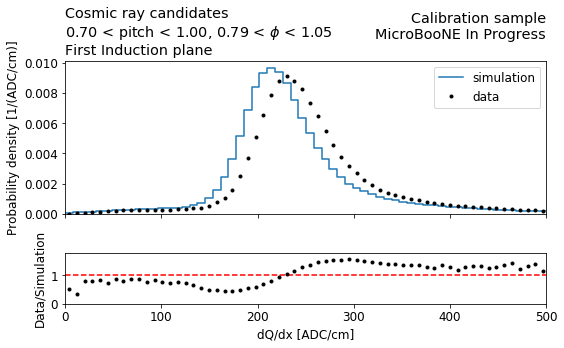

In [16]:
caloLike_calibration.plotLookUpDedxDataMC(plane_num=0,
                        pdg_code=13, 
                        data_selection='default',
                        parameters_value=[0.8, 0.9],
                        add_to_title='Calibration sample',
                        axis_label='dqdx')
plt.xlim(0, 500)
plt.tight_layout()
plt.savefig(save_folder+'plane_0_pitch_07_phi079.png', dpi=250)

/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:455: RuntimeWarning: divide by zero encountered in true_divide
  bin_contents_ratio = bin_contents_data / bin_contents_mc


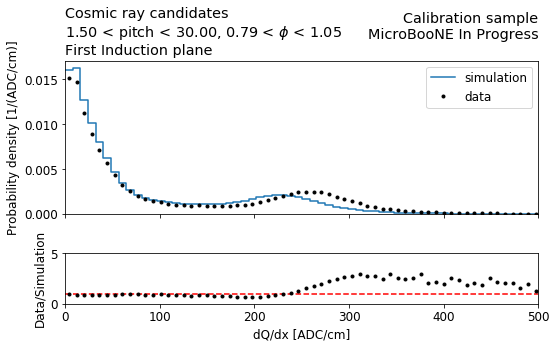

In [17]:
caloLike_calibration.plotLookUpDedxDataMC(plane_num=0,
                        pdg_code=13, 
                        data_selection='default',
                        parameters_value=[1.6, 0.9],
                        add_to_title='Calibration sample',
                        axis_label='dqdx')
plt.xlim(0, 500)
plt.tight_layout()
plt.savefig(save_folder+'plane_0_pitch_16_phi090.png', dpi=250)

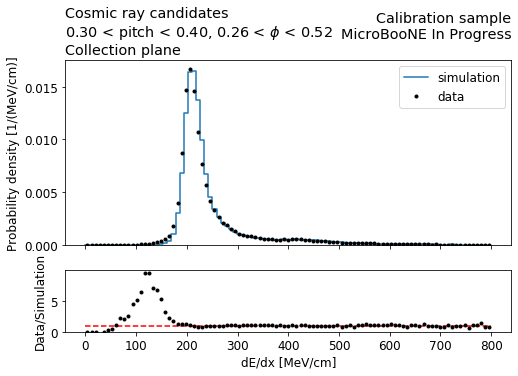

In [18]:
caloLike_calibration.plotLookUpDedxDataMC(plane_num=2,
                        pdg_code=13, 
                        data_selection='default',
                        parameters_value=[0.2, 0.4],
                        add_to_title='Calibration sample')

## Calibration only mu

In [19]:
def scale_calibration(mu, dedx):
    return dedx * mu[0]

In [20]:
caloLike_calibration.setCalibrationFunction(calibration_function=scale_calibration, 
                                n_calibration_parameters=1)

/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in greater_equal
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:486: RuntimeWarning: divide by zero encountered in log
  total_expectations - dedx_data_binned*np.log(total_expectations),


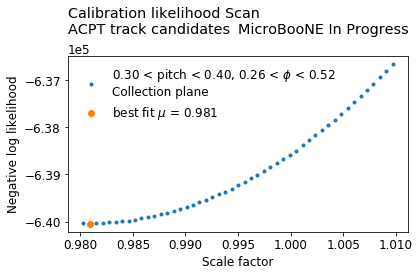

In [21]:
#example
caloLike_calibration.calibrationLikelihoodProfile(plane_num=2, 
                                                  parameters_value=[0.3, 0.4], 
                                                  pdg_code=13, 
                                                  start_point=[1],
                                                  data_selection='default', 
                                                  plot=True,
                                                  mu_binnings=[[0.98, 1.01, 50]])
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()
# plt.savefig(save_folder+'plane_2_pitch_0.75.png', dpi=250)

In [22]:
mu_scan_binning = [[0.9, 1.15, 50]]
for plane in [0, 1, 2]:
    caloLike_calibration.buildCalibrationTable(mu_scan_binning=mu_scan_binning, 
                          plane_num=plane, 
                          pdg_code=13, 
                          start_point=[1],
                          data_selection='default', 
                          plot_folder=save_folder_calibration+'plane{}/'.format(plane))
    edges, table = caloLike_calibration.plotCalibration2d(plane, annotated=True)
    plt.ylim(0.3, 1.5)
    plt.clim(0.85, 1.15) 
    plt.tight_layout()
    plt.savefig(save_folder_calibration+'calibration_table_plane_{}.png'.format(plane), dpi=200)
    plt.savefig(save_folder_calibration+'calibration_table_plane_{}.pdf'.format(plane))
    plt.close()

/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in greater_equal
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in less
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in greater_equal
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in less
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method 

[5, 6] [array([ 0.35,  0.55,  0.85,  1.25, 15.75]), array([0.13089969, 0.39269908, 0.65449847, 0.91629786, 1.17809725,
       1.43989663])]


/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  if sys.path[0] == '':
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in greater_equal
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in less
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in greater_equal
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/awkward

[5, 6] [array([ 0.35,  0.55,  0.85,  1.25, 15.75]), array([0.13089969, 0.39269908, 0.65449847, 0.91629786, 1.17809725,
       1.43989663])]


/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  if sys.path[0] == '':
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in greater_equal
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in less
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:486: RuntimeWarning: divide by zero encountered in log
  total_expectations - dedx_data_binned*np.log(total_expectations),
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/l

[5, 6] [array([ 0.35,  0.55,  0.85,  1.25, 15.75]), array([0.13089969, 0.39269908, 0.65449847, 0.91629786, 1.17809725,
       1.43989663])]


/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  if sys.path[0] == '':


In [23]:
# for plane in [0, 1, 2]:
#     edges, table = caloLike_calibration.plotCalibration2d(plane, annotated=True)
#     plt.ylim(0.3, 1.5)
#     plt.clim(0.85, 1.15)
#     plt.tight_layout()
#     plt.savefig(save_folder+'calibration_table_plane_{}.png'.format(plane), dpi=200)
#     plt.close()

In [24]:
#print table
# caloLike_calibration.printCplusplusCorrection(filename='/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/calorimetry_likelihood/larsoft_dev/LLRPID_correction_lookup.h', planes=[0, 1, 2])

In [25]:
#dump calibration object
# caloLike_calibration.save(filename='/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/calorimetry_likelihood/dumped_objects/calibration_pitch.dat')

## Plot pdf before and after - train set

In [19]:
load_calibration = True

In [20]:
caloLike_calibration2 = caloLikelihood(array_mc_train, quality_mask=muon_train, quality_masks_planes=mc_train_planes)
caloLike_calibration2.setCalibrationFunction(calibration_function=scale_calibration, 
                                n_calibration_parameters=1)
if load_calibration:
    filename = '/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/calorimetry_likelihood/dumped_objects/calibration_pitch.dat'
    caloLikelihood_load = caloLikelihood(None)
    caloLikelihood_load.load(filename)
    caloLike_calibration2.calibration_table = caloLikelihood_load.calibration_table
elif ~load_calibration:
    caloLike_calibration2.calibration_table = caloLike_calibration.calibration_table
else:
    print("you need to set load calibration")

In [21]:
caloLike_calibration2.setPdgCodeVar(pdgcode_var)
    
for i_pl, name_plane in zip([0, 1, 2], ['_u', '_v', '_y']):
    print(i_pl)
    this_parameters = [par+name_plane for par in parameters]
    caloLike_calibration2.setVariablesBinning(i_pl, this_parameters, parameters_bin_edges, dedx_vars+name_plane, dedx_bins, parameters_legend_names)
    caloLike_calibration2.buildLookUpTableMC(i_pl, 13, cali=True)

0
1
2


In [27]:
for plane_num in [0, 1, 2]:
    bin_centers = product(*caloLike_calibration.parameters_bin_centers[plane_num])
    for bin_center in bin_centers:
        calibration_index = caloLike_calibration.findLookUpRow(plane_num, bin_center)
        for plot in ['data_mc', 'data_mc_cali']:
            fig, ax = plt.subplots(ncols=1,
                                       nrows=2,
                                       figsize=(6.5, 5),
                                       sharex='col',
                                       gridspec_kw={'height_ratios': [3, 1]})

            plt.sca(ax[0])
            if plot == 'data_mc':
                bin_contents_mc = caloLike_calibration.plotLookUpDedxMCfancy(plane_num=plane_num,
                                pdg_code=13, 
                                parameters_value=bin_center,
                                title_left='Cosmic ray candidates\n', 
                                label='mc', 
                                axis_label='dqdx')
                
            elif plot == 'data_mc_cali':
                bin_contents_mc = caloLike_calibration.plotLookUpDedxMC(plane_num=plane_num,
                                        pdg_code=13, 
                                        parameters_value=bin_center, 
                                        label='mc', 
                                        axis_label='dqdx')
                mu = caloLike_calibration2.calibration_table[plane_num][calibration_index]
                bin_contents_mc_cali = caloLike_calibration2.plotLookUpDedxMCfancy(plane_num=plane_num,
                                        pdg_code=13, 
                                        parameters_value=bin_center,
                                        title_left='Cosmic ray candidates\n', 
                                        label='mc corrected\n$\mu$ = {:.3g}'.format(mu[0]), 
                                        axis_label='dqdx')

            bin_contents_data = caloLike_calibration.plotLookUpDedxData(plane_num=plane_num,
                                    data_selection='default', 
                                    parameters_value=bin_center, 
                                    axis_label='dqdx')

            plt.title('MicroBooNE in Progress', loc='right')
            dedx_bins_centers = caloLike_calibration.dedx_bins_centers[plane_num]
            dedx_bins_edges = caloLike_calibration.dedx_bin_edges[plane_num]
            plt.legend()
            plt.xlabel('')
            plt.xlim(0, 500)
    #             import pdb; pdb.set_trace()
            plt.sca(ax[1])
            plt.plot(dedx_bins_centers, bin_contents_data/bin_contents_mc, '.', label='mc')
            if plot == 'data_mc_cali':
                plt.plot(dedx_bins_centers, bin_contents_data/bin_contents_mc_cali, '.', label=r'mc corrected')
            plt.plot([dedx_bins_edges[0], dedx_bins_edges[-1]], [1, 1], '--k', alpha=0.3)
            plt.ylim(0.5, 2)
            plt.xlabel('dQ/dx [ADC/cm]')
            plt.ylabel('Data/Simulation')
            plt.tight_layout()
            if plot == 'data_mc':
                this_save_folder = save_folder_data_mc
            elif plot == 'data_mc_cali':
                this_save_folder = save_folder_data_mc_cali
            plt.savefig(this_save_folder + 'plane{}/pitch_{:.2f}_phi_{:.2f}'.format(plane_num, bin_center[0], bin_center[1]).replace('.', '')+'.png', dpi=250)
            plt.savefig(this_save_folder + 'plane{}/pitch_{:.2f}_phi_{:.2f}'.format(plane_num, bin_center[0], bin_center[1]).replace('.', '')+'.pdf')
            plt.close()

/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zer

# Plot integrated distribution dQ/dx, theta and phi

In [28]:
filename = '/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/calorimetry_likelihood/dumped_objects/calibration_pitch.dat'
caloLikelihood_cali = caloLikelihood(None)
caloLikelihood_cali.load(filename)

for plane_num, plane in enumerate(['u', 'v', 'y']):
    caloLike_calibration.array['dqdx_{}_cali'.format(plane)] = caloLikelihood_cali.calibrateDedxExternal(caloLike_calibration.array, plane_num)

/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:177: RuntimeWarning: invalid value encountered in greater
  np.where((parameter_value>parameter_bin_edges[0]) & (parameter_value<parameter_bin_edges[-1]),
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:177: RuntimeWarning: invalid value encountered in less
  np.where((parameter_value>parameter_bin_edges[0]) & (parameter_value<parameter_bin_edges[-1]),
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:179: RuntimeWarning: invalid value encountered in less_equal
  np.where((parameter_value<=parameter_bin_edges[0]),


In [34]:
variables = [
#              'trk_theta',
#              'trk_phi',
#              'trk_len',
             'dqdx_u',
             'dqdx_v',
             'dqdx_y',
            ]

binnings = {
    'trk_theta': [0, np.pi, 31],
    'trk_phi': [-np.pi, 0, 31],
    'trk_len': [30, 300, 15],
    'dqdx_u': [0, 600, 100],
    'dqdx_v': [0, 600, 100],
    'dqdx_y': [0, 600, 100],
}

plane2num = {
    'u': 0,
    'v': 1,
    'y': 2,
}

plane2string = {
    'u': 'First Induction Plane',
    'v': 'Second Induction Plane',
    'y': 'Collection Plane',
}

xlabels = {
    'trk_theta': r'Track $\theta$',
    'trk_phi': r'Track $\phi$',
    'trk_len': r'Track length [cm]',
    'dqdx_u': r'Hit dQ/dx [ADC/cm]',
    'dqdx_v': r'Hit dQ/dx [ADC/cm]',
    'dqdx_y': r'Hit dQ/dx [ADC/cm]',
}

ylabels = {
    'trk_theta': r'Probability density',
    'trk_phi': r'Probability density',
    'trk_len': r'Probability density [1/cm]',
    'dqdx_u': r'Probability density [1/(ADC/cm)]',
    'dqdx_v': r'Probability density [1/(ADC/cm)]',
    'dqdx_y': r'Probability density [1/(ADC/cm)]',
}

for var in variables:    
    binning = binnings[var]
    mc_mask = muon_train
    if 'dqdx' in var:
        i = plane2num[var[-1]]
        mc_mask = mc_mask & mc_train_planes[i]
            
    for plot in ['data_mc', 'data_mc_cali']:
        fig, ax = plt.subplots(ncols=1,
                                       nrows=2,
                                       figsize=(6.5, 5),
                                       sharex='col',
                                       gridspec_kw={'height_ratios': [3, 1]})

        plt.sca(ax[0])
    
        if plot == 'data_mc':
            mc_entries = caloLike_calibration.array[var][mc_mask].flatten()
            bin_contents_mc, bin_edges = np.histogram(mc_entries, range=(binning[0], binning[1]), bins=binning[2], density=True)
            bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
            plt.plot(bin_edges, np.append(bin_contents_mc, bin_contents_mc[-1]), label='mc', ds='steps-post')
        elif plot == 'data_mc_cali':
            mc_entries = caloLike_calibration.array[var][mc_mask].flatten()
            bin_contents_mc, bin_edges = np.histogram(mc_entries, range=(binning[0], binning[1]), bins=binning[2], density=True)
            bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
            plt.plot(bin_edges, np.append(bin_contents_mc, bin_contents_mc[-1]), label='mc', ds='steps-post')
            
            mc_entries = caloLike_calibration.array[var+'_cali'][mc_mask].flatten()
            bin_contents_mc_cali, bin_edges = np.histogram(mc_entries, range=(binning[0], binning[1]), bins=binning[2], density=True)
            plt.plot(bin_edges, np.append(bin_contents_mc_cali, bin_contents_mc_cali[-1]), label='mc corrected', ds='steps-post')
        
        left_title = 'Cosmic ray candidates'
        if 'dqdx' in var:
            left_title += '\n'
            left_title += plane2string[var[-1]]
        plt.title(left_title, loc='left')

        data_mask = data_train
        if 'dqdx' in var:
            i = plane2num[var[-1]]
            data_mask = data_mask & data_train_planes[i]

        data_entries = caloLike_calibration.array_data[var][data_mask].flatten()
        bin_contents_data, bin_edges = np.histogram(data_entries, range=(binning[0], binning[1]), bins=binning[2], density=True)
        plt.plot(bin_centers, bin_contents_data, 'k.', label='data')

        plt.title('MicroBooNE in Progress', loc='right')
        plt.legend()
        plt.xlabel('')
        plt.ylabel(ylabels[var])
        plt.ylim(bottom=0)
        plt.xlim(binning[0], binning[1])

        plt.sca(ax[1])
        plt.plot(bin_centers, bin_contents_data/bin_contents_mc, '.', label='mc')
        if plot == 'data_mc_cali':
            plt.plot(bin_centers, bin_contents_data/bin_contents_mc_cali, '.', label=r'mc corrected')
        plt.plot([bin_edges[0], bin_edges[-1]], [1, 1], '--k', alpha=0.3)
        plt.ylim(0.5, 2)
        plt.xlabel(xlabels[var])
        plt.ylabel('Data/Simulation')
        plt.tight_layout()

        plt.savefig(save_folder + '{}_{}'.format(var, plot) + '.png', dpi=250)
        plt.savefig(save_folder + '{}_{}'.format(var, plot) + '.pdf')
        plt.close()

# Studies for pitch-phi distribution in every bin

In [29]:
arrays = {
    'mc': array_mc_train, 
#     'data': array_data_train,
}

scale_factors = {
    'mc': 1., 
#     'data': 1.,
}

my_plotter = plotter(arrays, scale_factors, pot_beam_on=1, branch_weights_name=None)

In [30]:
title_base = "track len > 20 cm, downward going"

for plane_num, plane in zip([0, 1, 2], ['_u', '_v', '_y']):
    for par0_edges in zip(parameters_bin_edges[0][:-1], parameters_bin_edges[0][1:]):
        for par1_edges in zip(parameters_bin_edges[1][:-1], parameters_bin_edges[1][1:]):
            this_parameters = [par+plane for par in parameters]
            def sel_function(array):
                return (array['first_last_hit_mask'+plane]) &\
                       selection_mask(array) &\
                       (np.abs(array['backtracked_pdg'])==13) &\
                        ((array[this_parameters[0]]) > par0_edges[0]) &\
                        ((array[this_parameters[0]]) <= par0_edges[1]) &\
                        ((array[this_parameters[1]]) > par1_edges[0]) &\
                        ((array[this_parameters[1]]) <= par1_edges[1])
            label = 'plane {}, {:.2g} < {} < {:.2g} & {:.2g} < {} < {:.2g}'.format(plane_num, par0_edges[0], 
                                                         parameters_legend_names[0],
                                                         par0_edges[1],
                                                         par1_edges[0], 
                                                         parameters_legend_names[1],
                                                         par1_edges[1],)
            save_label = 'sim_{:.2f}_{}_{:.2f}_{:.2f}_{}_{:.2f}'.format( 
                                                         par0_edges[0], 
                                                         parameters_legend_names[0],
                                                         par0_edges[1],
                                                         par1_edges[0], 
                                                         parameters_legend_names[1],
                                                         par1_edges[1]).replace('.', '').replace('$', '').replace('\\', '')
            title = title_base + '\n' + label
            out = my_plotter.plot2d(dataset_name='mc', 
                                    variables=this_parameters, 
                                    binning=[15, par0_edges[0], par0_edges[1], 15, par1_edges[0], par1_edges[1]], 
                                    additional_selection=sel_function, 
                                    title="Simulated ACPT\n" + title,
                                    labels=["Hit pitch", r"Hit $\phi$"], 
                                    density=True,
                                    log=True)
            plt.tight_layout()
            plt.savefig(save_folder_pitch_phi + 'plane{}/'.format(plane_num) + save_label+'.png', dpi=300)
            plt.savefig(save_folder_pitch_phi + 'plane{}/'.format(plane_num) + save_label+'.pdf')
            plt.close()

/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in less
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in less_equal
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value enco

## As a function of run number

In [31]:
plt.hist(caloLike_train.array_data['run'], bins=50, alpha=0.5, label='train')
plt.hist(caloLike_test.array_data['run'], bins=50, alpha=0.5, label='test')
plt.legend()
plt.xlabel("run number")
plt.title("MicroBooNE in Progress", loc='right')
plt.title("Run number used for ACPT candidates\nBeam OFF data", loc='left')

NameError: name 'caloLike_train' is not defined

In [ ]:
plt.hist(caloLike_train.array['run'], bins=50, alpha=0.5, label='train')
plt.hist(caloLike_test.array['run'], bins=50, alpha=0.5, label='test')
plt.legend()
plt.xlabel("run number")
plt.title("MicroBooNE in Progress", loc='right')
plt.title("Run number used for ACPT candidates\nSimulation w/ overlay", loc='left')

In [ ]:
ar = caloLike_train.array
final_label = "\nACPT w/ overlay data\nTrain set"

In [ ]:
run = ar['run']
dedx_y = ar['dedx_y']
theta_z = ar['abs_theta_z_y']
theta_yx = ar['abs_theta_yx_y']
x = ar['x_y']

dedx_mask = (theta_z > 0) & (theta_z < 0.52) & (theta_yx > 0.39) & (theta_yx < 0.59) & mc_train_planes[2]

xlabel = {
    "dedx": "dE/dx - Y plane [MeV/cm]",
    "theta": r"$\theta$",
    "phi": r"$\phi$",
    "x": "x [cm]",
}

binnings = {
    "dedx" : [0, 4, 101],
    "theta" : [0, np.pi/2, 101],
    "phi" : [0, np.pi/2, 101],
    "x" : [-10, 270, 101],
}

arrays_here = {
    "dedx" : dedx_y,
    "theta" : theta_z,
    "phi" : theta_yx,
    "x" : x,
}

for var in ['dedx', 'theta', 'phi', 'x']:
    run_binning = [7000, 7200, 7600, 7800]
    for run_bins in zip(run_binning[:-1], run_binning[1:]):
        run_mask = (run > run_bins[0]) & (run < run_bins[1])
        aux = arrays_here[var][dedx_mask & run_mask].flatten()
        plt.hist(aux, 
                 bins=binnings[var][2], 
                 range=[binnings[var][0], binnings[var][1]], 
                 histtype='step', 
                 density=True, 
                 label='{} < run < {}\n{} hits\n{} tracks'.format(run_bins[0], run_bins[1], len(aux), 
                                                                  arrays_here[var][dedx_mask & run_mask].any().sum()))
    plt.legend()
    plt.xlabel(xlabel[var])
    plt.title("MicroBooNE in Progress", loc='right')
    plt.title("ACPT candidates\n" +
              r"{} < $\theta$ < {} & {} < $\phi$ < {}".format(0, 0.52, 0.39, 0.59) +
              final_label, loc='left')
    plt.tight_layout()
    plt.savefig(save_folder+var+"_bin_run.png", dpi=500)
    plt.close()

# Studies for pitch dependence for small pitch

In [15]:
dedx_binning = [100, 500]
dedx_n_bins = 150
pitch_binning = [0.3, 0.4, 0.5, 0.6, 0.7]
# pitch_binning = [0.3, 1, 1.5, 3, np.inf]

sel_mc = muon_train & mc_train_planes[2] & (array_mc_train['dqdx_y']>100) & (array_mc_train['dqdx_y']<400)
sel_data = data_train & data_train_planes[2] & (array_data_train['dqdx_y']>100) & (array_data_train['dqdx_y']<400)

for array, sel, name in zip([array_mc_train, array_data_train], [sel_mc, sel_data], ['simulation', 'data']):
    for pitch_bin in zip(pitch_binning[:-1], pitch_binning[1:]):
        pitch_mask = (array['pitch_y'] > pitch_bin[0]) & (array['pitch_y'] <= pitch_bin[1])
        
        dedx = array['dqdx_y'][pitch_mask & sel].flatten()
        
        sns.distplot(dedx, hist=False, kde=True,
                 kde_kws={'linewidth': 1},
                 label='{:.2g} < pitch < {:.2g}'.format(pitch_bin[0], pitch_bin[1]), norm_hist=True)
        
#         plt.hist(dedx, bins=dedx_n_bins, range=dedx_binning, density=True,
#                  label='{:.2g} < pitch < {:.2g}'.format(pitch_bin[0], pitch_bin[1]), histtype='step')
    
    plt.title('ACPT candidates in {}\n'.format(name)+
              'collection plane hits', loc='left')
    plt.title('MicroBooNE In Progress', loc='right')
    plt.xlabel('dQ/dx [ADC/cm]')
    plt.ylabel('Probability density [1/(ADC/cm)]')
    plt.legend()
    plt.tight_layout()
#     plt.savefig(save_folder+'dedx_different_low_pitch_{}.png'.format(name), dpi=250)
#     plt.savefig(save_folder+'dedx_different_low_pitch_{}.pdf'.format(name))
#     plt.savefig(save_folder+'dedx_different_large_pitch_{}.png'.format(name), dpi=250)
#     plt.savefig(save_folder+'dedx_different_large_pitch_{}.pdf'.format(name))
#     plt.close()
    break

KeyError: 'dqdx_y'

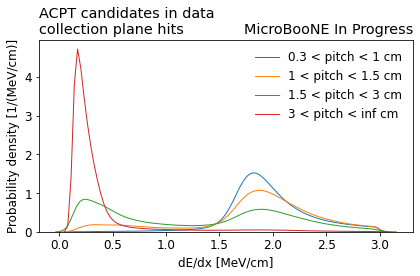

In [20]:
dedx_binning = [0, 3]
dedx_n_bins = 150
# pitch_binning = [0.3, 0.4, 0.5, 0.6, 0.7]
pitch_binning = [0.3, 1, 1.5, 3, np.inf]

sel_mc = muon_train & mc_train_planes[2] & (array_mc_train['dedx_y']>dedx_binning[0]) & (array_mc_train['dedx_y']<dedx_binning[1])
sel_data = data_train & data_train_planes[2] & (array_data_train['dedx_y']>dedx_binning[0]) & (array_data_train['dedx_y']<dedx_binning[1])

for array, sel, name in zip([array_mc_train, array_data_train], [sel_mc, sel_data], ['simulation', 'data']):
    if name == 'simulation':
        continue
    for pitch_bin in zip(pitch_binning[:-1], pitch_binning[1:]):
        pitch_mask = (array['pitch_y'] > pitch_bin[0]) & (array['pitch_y'] <= pitch_bin[1])
        
        dedx = array['dedx_y'][pitch_mask & sel].flatten()
        
        ax = sns.distplot(dedx, hist=False, kde=True,
                 kde_kws={'linewidth': 1},
                 label='{:.2g} < pitch < {:.2g} cm'.format(pitch_bin[0], pitch_bin[1]), norm_hist=True)
#         data_x, data_y = ax.lines[0].get_data()
#         print(data_y)
#         print(data_x[np.argmax(data_y)])
#         plt.hist(dedx, bins=dedx_n_bins, range=dedx_binning, density=True,
#                  label='{:.2g} < pitch < {:.2g}'.format(pitch_bin[0], pitch_bin[1]), histtype='step')
    
    plt.title('ACPT candidates in {}\n'.format(name)+
              'collection plane hits', loc='left')
    plt.title('MicroBooNE In Progress', loc='right')
    plt.xlabel('dE/dx [MeV/cm]')
    plt.ylabel('Probability density [1/(MeV/cm)]')
    plt.legend(frameon=False)
    plt.tight_layout()
#     plt.savefig(save_folder+'dedx_true_different_low_pitch_{}.png'.format(name), dpi=250)
#     plt.savefig(save_folder+'dedx_true_different_low_pitch_{}.pdf'.format(name))
    plt.savefig(save_folder+'dedx_true_different_large_pitch_{}.png'.format(name), dpi=250)
    plt.savefig(save_folder+'dedx_true_different_large_pitch_{}.pdf'.format(name))
#     plt.close()

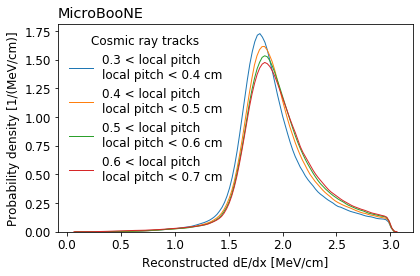

In [17]:
# for paper
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
save_folder_paper = '/home/nic/Dropbox/MicroBooNE/_fig/calorimetry/paper/'

dedx_binning = [0, 3]
dedx_n_bins = 150
pitch_binning = [0.3, 0.4, 0.5, 0.6, 0.7]
# pitch_binning = [0.3, 1, 1.5, 3, np.inf]

sel_mc = muon_train & mc_train_planes[2] & (array_mc_train['dedx_y']>dedx_binning[0]) & (array_mc_train['dedx_y']<dedx_binning[1])
sel_data = data_train & data_train_planes[2] & (array_data_train['dedx_y']>dedx_binning[0]) & (array_data_train['dedx_y']<dedx_binning[1])

for array, sel, name in zip([array_mc_train, array_data_train], [sel_mc, sel_data], ['simulation', 'data']):
    if name == 'simulation':
        continue
    for pitch_bin in zip(pitch_binning[:-1], pitch_binning[1:]):
        pitch_mask = (array['pitch_y'] > pitch_bin[0]) & (array['pitch_y'] <= pitch_bin[1])
        
        dedx = array['dedx_y'][pitch_mask & sel].flatten()
        
        ax = sns.distplot(dedx, hist=False, kde=True,
                 kde_kws={'linewidth': 1},
                 label='{:.2g} < local pitch\nlocal pitch < {:.2g} cm'.format(pitch_bin[0], pitch_bin[1]), norm_hist=True)
#         data_x, data_y = ax.lines[0].get_data()
#         print(data_y)
#         print(data_x[np.argmax(data_y)])
#         plt.hist(dedx, bins=dedx_n_bins, range=dedx_binning, density=True,
#                  label='{:.2g} < pitch < {:.2g}'.format(pitch_bin[0], pitch_bin[1]), histtype='step')
    
    plt.title('MicroBooNE', loc='left')
    plt.xlabel('Reconstructed dE/dx [MeV/cm]')
    plt.ylabel('Probability density [1/(MeV/cm)]')
    plt.legend(title='Cosmic ray tracks', frameon=False, loc='upper left')
    plt.tight_layout()
    plt.savefig(save_folder_paper+'dedx_true_different_low_pitch_{}.png'.format(name), dpi=250)
    plt.savefig(save_folder_paper+'dedx_true_different_low_pitch_{}.pdf'.format(name))
#     plt.savefig(save_folder_paper+'dedx_true_different_large_pitch_{}.png'.format(name), dpi=250)
#     plt.savefig(save_folder_paper+'dedx_true_different_large_pitch_{}.pdf'.format(name))
#     plt.close()

In [19]:
for i in range(4):
    data_x, data_y = ax.lines[i].get_data()
    print(data_x[np.argmax(data_y)])

1.7849082457942003
1.825949704514395
1.8425205440757324
1.843009642051325


In [2]:
(1.8385554379696092 - 1.7747256825076285)/1.7747256825076285

0.03596598397775556

In [31]:
pdf(1.7747256825076285)

array(-1.72903325)

In [21]:
xmax = [] 
for i in range(4):
    data_x, data_y = ax.lines[i].get_data()
    pdf = sp.interpolate.interp1d(data_x, (-1)*data_y, kind='cubic')
    res = sp.optimize.minimize_scalar(pdf, method='Bounded', bounds=[1.5, 2])
    xmax.append(res.x)

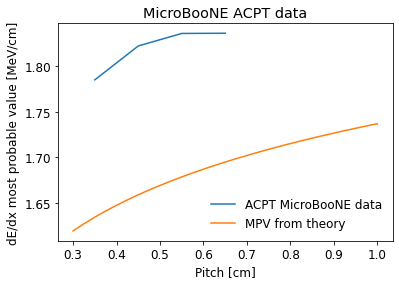

In [23]:
plt.plot([0.35, 0.45, 0.55, 0.65], xmax, label='ACPT MicroBooNE data')
plt.plot(np.linspace(0.3, 1, 30), [1.619787444019617,
 1.6273142131960032,
 1.6343001161899466,
 1.6408177010693261,
 1.6469258321814808,
 1.6526729288208977,
 1.6580992990291639,
 1.6632388559170148,
 1.6681204027418035,
 1.6727686105682849,
 1.6772047727462696,
 1.6814473946835318,
 1.6855126602616153,
 1.689414804617027,
 1.6931664149767522,
 1.6967786755930432,
 1.7002615687969715,
 1.7036240412791617,
 1.7068741425739329,
 1.7100191411429304,
 1.7130656222704013,
 1.7160195710862376,
 1.7188864433482909,
 1.7216712260877582,
 1.7243784898113363,
 1.727012433632594,
 1.729576924451606,
 1.7320755311005605,
 1.7345115542120997,
 1.7368880524376553], label='MPV from theory')
plt.xlabel('Pitch [cm]')
plt.ylabel('dE/dx most probable value [MeV/cm]')
plt.title('MicroBooNE ACPT data')
plt.legend(frameon=False)
plt.savefig(save_folder_paper+'dedx_vs_pitch.png'.format(name), dpi=250)
plt.savefig(save_folder_paper+'dedx_vs_pitch.pdf'.format(name))

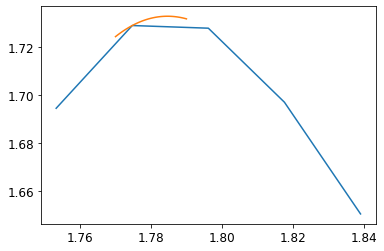

In [45]:
x_test = np.linspace(1.77, 1.79, 100)
y_test = pdf(x_test)
plt.plot(data_x[38:43], data_y[38:43])
plt.plot(x_test, y_test*(-1))

[204.6046046]
[208.60860861]
[207.00700701]
[209.80980981]


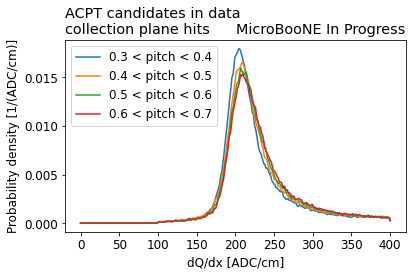

In [35]:
from sklearn.neighbors import KernelDensity

dedx_binning = [100, 500]
dedx_n_bins = 150
pitch_binning = [0.3, 0.4, 0.5, 0.6, 0.7]
# pitch_binning = [0.3, 1, 1.5, 3, np.inf]

sel_mc = muon_train & mc_train_planes[2] & (array_mc_train['dqdx_y']>100) & (array_mc_train['dqdx_y']<400)
sel_data = data_train & data_train_planes[2] & (array_data_train['dqdx_y']>100) & (array_data_train['dqdx_y']<400)

for array, sel, name in zip([array_mc_train, array_data_train], [sel_mc, sel_data], ['simulation', 'data']):
    if name == 'simulation':
        continue
    for pitch_bin in zip(pitch_binning[:-1], pitch_binning[1:]):
        pitch_mask = (array['pitch_y'] > pitch_bin[0]) & (array['pitch_y'] <= pitch_bin[1])
        
        dedx = array['dqdx_y'][pitch_mask & sel].flatten()[:, np.newaxis]
        
        kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(dedx)
        x = np.linspace(0, 400, 1000)[:, np.newaxis]
        log_density_values = kde.score_samples(x)
        print(x[np.argmax(log_density_values)])
        
        plt.plot(x, np.exp(log_density_values), label='{:.2g} < pitch < {:.2g}'.format(pitch_bin[0], pitch_bin[1]))
    
    plt.title('ACPT candidates in {}\n'.format(name)+
              'collection plane hits', loc='left')
    plt.title('MicroBooNE In Progress', loc='right')
    plt.xlabel('dQ/dx [ADC/cm]')
    plt.ylabel('Probability density [1/(ADC/cm)]')
    plt.legend()
    plt.tight_layout()
#     plt.savefig(save_folder+'dedx_different_low_pitch_{}.png'.format(name), dpi=250)
#     plt.savefig(save_folder+'dedx_different_low_pitch_{}.pdf'.format(name))
#     plt.savefig(save_folder+'dedx_different_large_pitch_{}.png'.format(name), dpi=250)
#     plt.savefig(save_folder+'dedx_different_large_pitch_{}.pdf'.format(name))
#     plt.close()

### Dump, load and closure test calibration

In [ ]:
#load calibration table
# caloLike_table = caloLikelihood(None)
# caloLike_table.load(filename='/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/calorimetry_likelihood/dumped_objects/calibration_pitch.dat')
# caloLike_calibration.calibration_table = caloLike_table.calibration_table

In [ ]:
#1
caloLike_dump_test1 = caloLikelihood(array_mc_test, quality_mask=muon_test, quality_masks_planes=mc_test_planes)
caloLike_dump_test1.setPdgCodeVar(pdgcode_var)
i=1
caloLike_dump_test1.setVariablesBinning(i, parameters[i], parameters_bin_edges, dedx_vars[i], np.linspace(0, 10000, 100), parameters_legend_names[i])
caloLike_dump_test1.setCalibrationFunction(calibration_function=scale_calibration, n_calibration_parameters=1)
caloLike_dump_test1.calibration_table = caloLike_calibration.calibration_table
caloLike_dump_test1.buildLookUpTableMC(i, 13, cali=True)

In [ ]:
#2
caloLikelihood_cali_trail = caloLikelihood(None)
caloLikelihood_cali_trail.load(filename='/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/calorimetry_likelihood/dumped_objects/calibration.dat')
array_mc_test['dedx_v_cali'] = caloLikelihood_cali_trail.calibrateDedxExternal(array_mc_test, 1)
caloLike_dump_test2 = caloLikelihood(array_mc_test, quality_mask=muon_test, quality_masks_planes=mc_test_planes)
caloLike_dump_test2.setPdgCodeVar(pdgcode_var)
i=1
caloLike_dump_test2.setVariablesBinning(i, parameters[i], parameters_bin_edges, 'dedx_v_cali', np.linspace(0, 10000, 100), parameters_legend_names[i])
caloLike_dump_test2.buildLookUpTableMC(i, 13, cali=False)

In [ ]:
(caloLike_dump_test1.lookup_tables[13][1] - caloLike_dump_test2.lookup_tables[13][1]).any()